In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
import torch.utils.data.sampler as sampler

import os
import fnmatch
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
class CityScapes(Dataset):
    def __init__(self, root, train=True):
        self.train = train
        self.root = os.path.expanduser(root)

        # read the data file
        if train:
            self.data_path = os.path.join(root, 'train')
        else:
            self.data_path = os.path.join(root, 'val')

        # calculate data length
        self.data_len = len(fnmatch.filter(os.listdir(os.path.join(self.data_path, 'image')), '*.npy'))

    def __getitem__(self, index):
        # load data from the pre-processed npy files
        image = torch.from_numpy(np.moveaxis(np.load(os.path.join(self.data_path, 'image', '{:d}.npy'.format(index))), -1, 0))
        semantic = torch.from_numpy(np.load(os.path.join(self.data_path, 'label', '{:d}.npy'.format(index))))
        depth = torch.from_numpy(np.moveaxis(np.load(os.path.join(self.data_path, 'depth', '{:d}.npy'.format(index))), -1, 0))
        
        return {'image': image.float(), 'semantic': semantic.float(), 'depth': depth.float()}

    def __len__(self):
        return self.data_len


In [3]:
dataset_path = 'dataset/data'
train_set = CityScapes(root=dataset_path, train=True)
test_set = CityScapes(root=dataset_path, train=False)

In [4]:
from collections import namedtuple
# a label and all meta information
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      20 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      20 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      20 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      20 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      20 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      20 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      20 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      20 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      20 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      20 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      20 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      20 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      20 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      20 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      20 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       19 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]


torch.Size([3, 108, 256]) torch.Size([103, 256]) torch.Size([1, 108, 256])


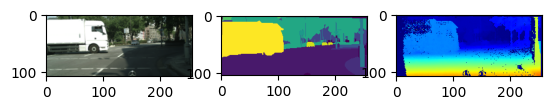

In [5]:
img_dict = test_set.__getitem__(21)
img = img_dict['image'][:, :-20]
sem = img_dict['semantic'][:-25, :]
depth = img_dict['depth'][:, :-20]
print(img.shape, sem.shape, depth.shape)

plt.subplot(1,3,1)
plt.imshow(img.permute(1, 2, 0))
plt.subplot(1,3,2)
plt.imshow(sem)
plt.subplot(1,3,3)
plt.imshow(depth.permute(1, 2, 0), cmap='jet')

In [6]:
from torch . utils . data import DataLoader
batch_size = 2
train_loader = DataLoader ( train_set , batch_size = batch_size , shuffle = True )
test_loader = DataLoader ( test_set , batch_size = batch_size , shuffle = False )

In [7]:
for i, batch in tqdm(enumerate(train_loader)):
    print(batch['depth'].shape,batch['semantic'].shape )
    break

0it [00:00, ?it/s]

torch.Size([2, 1, 128, 256]) torch.Size([2, 128, 256])


In [8]:
def compute_loss(x_pred, x_output, task_type):
    device = x_pred.device

    # binary mark to mask out undefined pixel space
    binary_mask = (torch.sum(x_output, dim=1) != 0).float().unsqueeze(1).to(device)

    if task_type == 'semantic':
        # semantic loss : depth - wise cross entropy
        loss = F.nll_loss(x_pred, x_output, ignore_index=-1)

    if task_type == 'depth':
        # depth loss : l1 norm
        loss = torch.sum(torch.abs(x_pred - x_output) * binary_mask) / torch.nonzero(
            binary_mask, as_tuple=False).size(0)

    return loss
xx = torch.rand(4,13,128,256)
yy = torch.rand(4,128,256).long()
print(compute_loss(xx,yy,'semantic'))

tensor(-0.4987)


In [9]:
import torch.nn as nn

class GLPDepthWithSegmentation(nn.Module):
    def __init__(self):
        super(GLPDepthWithSegmentation, self).__init__()
        # initialise network parameters

        filter = [64, 128, 256, 512, 512]

        self.class_nb = 21

        # define encoder decoder layers
        self.ViT_encoder_block = nn.ModuleList([self.conv_layer([3, filter[0]])])
        self.decoder_block = nn.ModuleList([self.conv_layer([filter[0], filter[0]])])
        for i in range(4):
            self.ViT_encoder_block.append(self.conv_layer([filter[i], filter[i + 1]]))
            self.decoder_block.append(self.conv_layer([filter[i + 1], filter[i]]))

        # define convolution layer
        self.tranformer_block = nn.ModuleList([self.conv_layer([filter[0], filter[0]])])
        self.mlp = nn.ModuleList([self.conv_layer([filter[0], filter[0]])])
        for i in range(4):
            if i == 0:
                self.tranformer_block.append(self.conv_layer([filter[i + 1], filter[i + 1]]))
                self.mlp.append(self.conv_layer([filter[i], filter[i]]))
            else:
                self.tranformer_block.append(nn.Sequential(self.conv_layer([filter[i + 1], filter[i + 1]]),
                                                          self.conv_layer([filter[i + 1], filter[i + 1]])))
                self.mlp.append(nn.Sequential(self.conv_layer([filter[i], filter[i]]),
                                                          self.conv_layer([filter[i], filter[i]])))

        # define task specific layers
        self.SegFormerDecoder = nn.Sequential(nn.Conv2d(in_channels=filter[0], out_channels=filter[0], kernel_size=3, padding=1),
                                         nn.Conv2d(in_channels=filter[0], out_channels=self.class_nb, kernel_size=1, padding=0))
        self.GLPDepthDecoder = nn.Sequential(nn.Conv2d(in_channels=filter[0], out_channels=filter[0], kernel_size=3, padding=1),
                                         nn.Conv2d(in_channels=filter[0], out_channels=1, kernel_size=1, padding=0))

        # define pooling and unpooling functions
        self.down_sampling = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.up_sampling = nn.MaxUnpool2d(kernel_size=2, stride=2)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    # define convolutional block
    def conv_layer(self, channel):
        conv_block = nn.Sequential(
            nn.Conv2d(in_channels=channel[0], out_channels=channel[1], kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=channel[1]),
            nn.GELU()
        )
        return conv_block

    def forward(self, x):
        g_encoder, g_decoder, g_maxpool, g_upsampl, indices = ([0] * 5 for _ in range(5))
        for i in range(5):
            g_encoder[i], g_decoder[-i - 1] = ([0] * 2 for _ in range(2))

        # global shared encoder - decoder network
        for i in range(5):
            if i == 0:
                g_encoder[i][0] = self.ViT_encoder_block[i](x)
                g_encoder[i][1] = self.tranformer_block[i](g_encoder[i][0])
                g_maxpool[i], indices[i] = self.down_sampling(g_encoder[i][1])
            else:
                g_encoder[i][0] = self.ViT_encoder_block[i](g_maxpool[i - 1])
                g_encoder[i][1] = self.tranformer_block[i](g_encoder[i][0])
                g_maxpool[i], indices[i] = self.down_sampling(g_encoder[i][1])

        for i in range(5):
            if i == 0:
                g_upsampl[i] = self.up_sampling(g_maxpool[-1], indices[-i - 1])
                g_decoder[i][0] = self.decoder_block[-i - 1](g_upsampl[i])
                g_decoder[i][1] = self.mlp[-i - 1](g_decoder[i][0])
            else:
                g_upsampl[i] = self.up_sampling(g_decoder[i - 1][-1], indices[-i - 1])
                g_decoder[i][0] = self.decoder_block[-i - 1](g_upsampl[i])
                g_decoder[i][1] = self.mlp[-i - 1](g_decoder[i][0])

        # define task prediction layers
        pred_seg = F.log_softmax(self.SegFormerDecoder(g_decoder[i][1]), dim=1)
        pred_d = self.GLPDepthDecoder(g_decoder[i][1])

        return {'semantic': pred_seg, 'depth': pred_d}


In [10]:
from tqdm import tqdm

def train_epoch(train_loader, model, device, optimizer):
    # iteration for all batches
    model.train()
    losses = {'semantic': [], 'depth': [], 'total': []}
    for i, batch in tqdm(enumerate(train_loader)):
        images = batch['image'].to(device)
        semantic = batch['semantic'].long().to(device)
        depth = batch['depth'].to(device)
        output = model(images)


        optimizer.zero_grad()
        train_loss = {
            'semantic': compute_loss(output['semantic'], semantic, 'semantic'),
            'depth': compute_loss(output['depth'], depth, 'depth')
        }

        loss = train_loss['semantic'] + train_loss['depth']

        loss.backward()
        optimizer.step()

        losses['semantic'].append(train_loss['semantic'].item())
        losses['depth'].append(train_loss['depth'].item())
        losses['total'].append(loss.item())

    avg_losses = {task: sum(task_loss) / len(task_loss) for task, task_loss in losses.items()}
    print(1)
    return avg_losses

def evaluation_epoch(val_loader, model, device):
    # iteration for all batches
    model.eval()
    losses = {'semantic': [], 'depth': [], 'total': []}
    with torch.no_grad():
        for i, batch in tqdm(enumerate(val_loader)):
            images = batch['image'].to(device)
            semantic = batch['semantic'].long().to(device)
            depth = batch['depth'].to(device)

            output = model(images)

            # Process semantic output
            semantic_output = torch.argmax(output['semantic'], dim=1).squeeze()

            train_loss = {
                'semantic': compute_loss(output['semantic'], semantic, 'semantic'),
                'depth': compute_loss(output['depth'], depth, 'depth')
            }

            loss = train_loss['semantic'] + train_loss['depth']

            losses['semantic'].append(train_loss['semantic'].item())
            losses['depth'].append(train_loss['depth'].item())
            losses['total'].append(loss.item())

    avg_losses = {task: sum(task_loss) / len(task_loss) for task, task_loss in losses.items()}
    return avg_losses


def train(train_loader, val_loader, model, device, optimizer, scheduler, epochs):
    best_loss = 100.
    for epoch in range(epochs):
        train_loss = train_epoch(train_loader, model, device, optimizer)
        val_loss = evaluation_epoch(test_loader, model, device)  # Thay đổi từ train_epoch sang evaluation_epoch
        scheduler.step()
        print(train_loss, val_loss)
            
        print('Epoch: {:04d} | Train: Semantic Loss {:.4f} - Depth Loss {:.4f} - Total Loss {:.4f} || '
              'Eval: Semantic Loss {:.4f} - Depth Loss {:.4f} - Total Loss {:.4f}'
              .format(epoch + 1, train_loss['semantic'], train_loss['depth'], train_loss['total'],
                      val_loss['semantic'], val_loss['depth'], val_loss['total']))
        #         if val_loss['total'] < best_loss:
        if epoch == 99:
            best_loss = val_loss['total']
            torch.save(model.state_dict(), '/kaggle/working/GLPWIthSegFormer.pth')
            print(f"Model saved: /kaggle/working/GLPWIthSegFormer.pth")
            torch.save(model, '/kaggle/working/GLPWIthSegFormer')
            print(f"Model saved: /kaggle/working/GLPWIthSegFormer.pth")
    return model


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
model = GLPDepthWithSegmentation()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

epochs = 100
# model = train(train_loader, test_loader, model, device, optimizer, scheduler, epochs)


In [11]:
# torch.save(model.state_dict(), '/kaggle/working/GLPWIthSegFormer_v1.pth')
# print(f"Model saved: /kaggle/working/GLPWIthSegFormer_v1.pth")
# torch.save(model, '/kaggle/working/GLPWithSegFormerModel')
# print(f"Model saved: /kaggle/working/GLPWithSegFormer")

In [12]:
import torch
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

class SegmentationDepthModel(torch.nn.Module):
    """
    A wrapper module that loads:
      - A lightweight semantic segmentation model (DeepLabV3 with a MobileNet V3 backbone)
      - A lightweight monocular depth estimation model (MiDaS_small)
    It accepts a PIL image in RGB and returns a dictionary with keys:
      'segmentation' and 'depth'
    """
    def __init__(self, device="cuda" if torch.cuda.is_available() else "cpu"):
        super().__init__()
        self.device = device

        # -------------------------------
        # Load Semantic Segmentation Model
        # -------------------------------
        self.seg_processor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
        self.seg_model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
        self.seg_model.to(self.device).eval()


        # -------------------------------
        # Load Monocular Depth Estimation Model (MiDaS_small)
        # -------------------------------
        # Loading the small MiDaS model using torch.hub
        self.depth_model = torch.hub.load("intel-isl/MiDaS", "MiDaS_small")
        self.depth_model.to(self.device)
        self.depth_model.eval()

        # Load MiDaS transforms (small_transform)
        midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
        self.depth_transform = midas_transforms.small_transform

    def forward(self, img):
        """
        Processes an input PIL image and returns both predictions.
        
        Args:
            img (PIL.Image): Input image in RGB format.
        
        Returns:
            dict: A dictionary with keys:
                - 'segmentation': A 2D NumPy array containing the semantic segmentation mask.
                - 'depth': A 2D NumPy array representing the estimated depth map.
        """
        # Remember the original image size.
        orig_width, orig_height = img.size

        # -------------------------------
        # Semantic Segmentation Path
        # -------------------------------
        seg_inputs = self.seg_processor(images=img, return_tensors="pt")
        seg_inputs = {k: v.to(self.device) for k, v in seg_inputs.items()}
        with torch.no_grad():
            seg_output = self.seg_model(**seg_inputs)
        seg_logits = seg_output.logits  # [1, num_classes, H, W]
        seg_preds = seg_logits.argmax(dim=1)[0].cpu().numpy()
        seg_prediction = cv2.resize(seg_preds.astype(np.uint8), (orig_width, orig_height), interpolation=cv2.INTER_NEAREST)

        # -------------------------------
        # Monocular Depth Estimation Path
        # -------------------------------
        # Convert the PIL image to a NumPy array before passing to the transform.
        img_np = np.array(img)
        depth_input = self.depth_transform(img_np).to(self.device)
        with torch.no_grad():
            depth_out = self.depth_model(depth_input)  # Shape: [1, 256, 256]
            depth_out = depth_out.unsqueeze(1)  # Now shape: [1, 1, 256, 256]
        # Upsample depth output to the original image size
        print(f"Depth output shape: {depth_out.shape}")
        print(f"Original image size: {orig_height}, {orig_width}")
        # Upsample depth output to original size
        # The depth map is resized to the original image size.
        depth_out = torch.nn.functional.interpolate(
            depth_out,
            size=(orig_height, orig_width),
            mode="bilinear",
            align_corners=False
        )
        depth_map = depth_out.squeeze().cpu().numpy()

        return {"segmentation": seg_prediction, "depth": depth_map}


In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SegmentationDepthModel(device=device)

c:\Users\abd\d\ai\dehaze\.venv\Lib\site-packages\transformers\models\segformer\feature_extraction_segformer.py:30: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
c:\Users\abd\d\ai\dehaze\.venv\Lib\site-packages\transformers\utils\deprecation.py:172: UserWarning: The following named arguments are not valid for `SegformerFeatureExtractor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)
Using cache found in C:\Users\abd/.cache\torch\hub\intel-isl_MiDaS_master
c:\Users\abd\d\ai\dehaze\.venv\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Loading weights:  None


Using cache found in C:\Users\abd/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master
Using cache found in C:\Users\abd/.cache\torch\hub\intel-isl_MiDaS_master


Depth output shape: torch.Size([1, 1, 128, 256])
Original image size: 128, 256
torch.Size([2, 3, 128, 256]) (128, 256) (128, 256)
torch.Size([2, 3, 128, 256]) torch.Size([2, 128, 256]) torch.Size([2, 1, 128, 256])


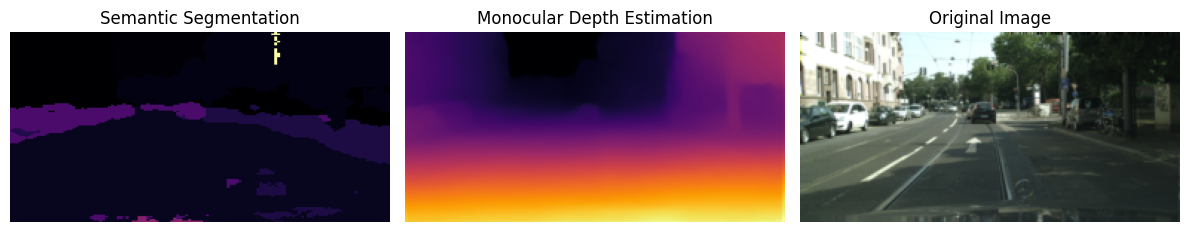

In [14]:
def visualize_results(images, semantic_output, depth_output):
    # num_images = len(images)
    # fig, axes = plt.subplots(num_images, 3, figsize=(15, num_images * 5))
    
    # for i in range(num_images):
    #     axes[i, 0].imshow(images[i].cpu().numpy().transpose((1, 2, 0)))
    #     axes[i, 0].set_title('Original Image')
    #     axes[i, 0].axis('off')
        
    #     axes[i, 1].imshow(semantic_output[i].cpu().numpy(), cmap='viridis')
    #     axes[i, 1].set_title('Semantic Output')
    #     axes[i, 1].axis('off')
        
    #     axes[i, 2].imshow(depth_output[i].cpu().numpy(), cmap='viridis')
    #     axes[i, 2].set_title('Depth Output')
    #     axes[i, 2].axis('off')
    
    # plt.tight_layout()
    # plt.show()
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(semantic_output, cmap="inferno")
    plt.title("Semantic Segmentation")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(depth_output, cmap="inferno")
    plt.title("Monocular Depth Estimation")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(images)
    plt.title("Original Image")
    plt.axis("off")

    plt.tight_layout()
    plt.show()
    
import matplotlib.pyplot as plt
import numpy as np
import torch

# === Cityscapes Color Palette Based on Train ID ===
cityscapes_trainid_to_color = {
    0:  (128, 64, 128),     # road
    1:  (244, 35, 232),     # sidewalk
    2:  (70, 70, 70),       # building
    3:  (102, 102, 156),    # wall
    4:  (190, 153, 153),    # fence
    5:  (153, 153, 153),    # pole
    6:  (250, 170, 30),     # traffic light
    7:  (220, 220, 0),      # traffic sign
    8:  (107, 142, 35),     # vegetation
    9:  (152, 251, 152),    # terrain
    10: (70, 130, 180),     # sky
    11: (220, 20, 60),      # person
    12: (255, 0, 0),        # rider
    13: (0, 0, 142),        # car
    14: (0, 0, 70),         # truck
    15: (0, 60, 100),       # bus
    16: (0, 80, 100),       # train
    17: (0, 0, 230),        # motorcycle
    18: (119, 11, 32),      # bicycle
    19: (0, 0, 142),        # license plate (ignoreInEval)
    20: (0, 0, 0)           # unlabeled / ignored
}

# === Function to decode semantic mask ===
def decode_semantic_mask(sem_mask, palette):
    """
    Convert a 2D semantic mask (with train IDs) to a color RGB image.
    """
    h, w = sem_mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for train_id, color in palette.items():
        color_mask[sem_mask == train_id] = color
    return color_mask

# === Modified Visualization Function ===
def visualize_results1(images, semantic_output, depth_output):
    num_images = len(images)
    fig, axes = plt.subplots(num_images, 3, figsize=(15, num_images * 5))

    for i in range(num_images):
        # Original image
        img_np = images[i].cpu().numpy().transpose((1, 2, 0))
        axes[i, 0].imshow(img_np)
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')
        
        # Semantic output (Cityscapes palette)
        sem_np = semantic_output[i].cpu().numpy().astype(np.uint8)
        sem_rgb = decode_semantic_mask(sem_np, cityscapes_trainid_to_color)
        axes[i, 1].imshow(sem_rgb)
        axes[i, 1].set_title('Semantic Label (Cityscapes)')
        axes[i, 1].axis('off')
        
        # Depth output
        depth_np = depth_output[i].cpu().numpy()
        if depth_np.ndim == 3 and depth_np.shape[0] == 1:
            depth_np = depth_np.squeeze(0)
        axes[i, 2].imshow(depth_np, cmap='jet')
        axes[i, 2].set_title('Depth Label')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

import torchvision.transforms as T
to_pil = T.ToPILImage()
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        if i < 3:
            continue
        images = batch['image'].to(device)
        semantic = batch['semantic'].long().to(device)
        depth = batch['depth'].to(device)
        
        img = to_pil(images[0])
        output = model(img)
        semantic_output = output['segmentation']
        semantic_label = torch.argmax(batch['semantic'], dim=1).squeeze()
        depth_output = output["depth"]

        print(images.shape, semantic_output.shape, output['depth'].squeeze().shape)
        print(images.shape, semantic.shape, depth.shape)
        # If your semantic_output is a NumPy array of shape (128, 256)
        # semantic_output = torch.from_numpy(semantic_output)  # Convert to tensor

        # # Then you can expand the batch dimension
        # batched_output = semantic_output.unsqueeze(0).repeat(2, 1, 1)

        visualize_results(img, semantic_output, depth_output)
        # visualize_results1(images,batched_output , depth.squeeze())
        break

Depth output shape: torch.Size([1, 1, 128, 256])
Original image size: 1024, 2048


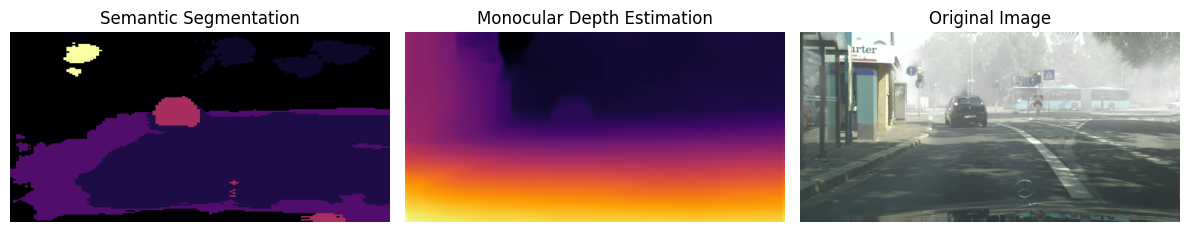

In [15]:
def visualize_results(images, semantic_output, depth_output):
    # num_images = len(images)
    # fig, axes = plt.subplots(num_images, 3, figsize=(15, num_images * 5))
    
    # for i in range(num_images):
    #     axes[i, 0].imshow(images[i].cpu().numpy().transpose((1, 2, 0)))
    #     axes[i, 0].set_title('Original Image')
    #     axes[i, 0].axis('off')
        
    #     axes[i, 1].imshow(semantic_output[i].cpu().numpy(), cmap='viridis')
    #     axes[i, 1].set_title('Semantic Output')
    #     axes[i, 1].axis('off')
        
    #     axes[i, 2].imshow(depth_output[i].cpu().numpy(), cmap='viridis')
    #     axes[i, 2].set_title('Depth Output')
    #     axes[i, 2].axis('off')
    
    # plt.tight_layout()
    # plt.show()
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(semantic_output, cmap="inferno")
    plt.title("Semantic Segmentation")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(depth_output, cmap="inferno")
    plt.title("Monocular Depth Estimation")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(images)
    plt.title("Original Image")
    plt.axis("off")

    plt.tight_layout()
    plt.show()
    
import matplotlib.pyplot as plt
import numpy as np
import torch

# === Cityscapes Color Palette Based on Train ID ===
cityscapes_trainid_to_color = {
    0:  (128, 64, 128),     # road
    1:  (244, 35, 232),     # sidewalk
    2:  (70, 70, 70),       # building
    3:  (102, 102, 156),    # wall
    4:  (190, 153, 153),    # fence
    5:  (153, 153, 153),    # pole
    6:  (250, 170, 30),     # traffic light
    7:  (220, 220, 0),      # traffic sign
    8:  (107, 142, 35),     # vegetation
    9:  (152, 251, 152),    # terrain
    10: (70, 130, 180),     # sky
    11: (220, 20, 60),      # person
    12: (255, 0, 0),        # rider
    13: (0, 0, 142),        # car
    14: (0, 0, 70),         # truck
    15: (0, 60, 100),       # bus
    16: (0, 80, 100),       # train
    17: (0, 0, 230),        # motorcycle
    18: (119, 11, 32),      # bicycle
    19: (0, 0, 142),        # license plate (ignoreInEval)
    20: (0, 0, 0)           # unlabeled / ignored
}

# === Function to decode semantic mask ===
def decode_semantic_mask(sem_mask, palette):
    """
    Convert a 2D semantic mask (with train IDs) to a color RGB image.
    """
    h, w = sem_mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for train_id, color in palette.items():
        color_mask[sem_mask == train_id] = color
    return color_mask

# === Modified Visualization Function ===
def visualize_results1(images, semantic_output, depth_output):
    num_images = len(images)
    fig, axes = plt.subplots(num_images, 3, figsize=(15, num_images * 5))

    for i in range(num_images):
        # Original image
        img_np = images[i].cpu().numpy().transpose((1, 2, 0))
        axes[i, 0].imshow(img_np)
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')
        
        # Semantic output (Cityscapes palette)
        sem_np = semantic_output[i].cpu().numpy().astype(np.uint8)
        sem_rgb = decode_semantic_mask(sem_np, cityscapes_trainid_to_color)
        axes[i, 1].imshow(sem_rgb)
        axes[i, 1].set_title('Semantic Label (Cityscapes)')
        axes[i, 1].axis('off')
        
        # Depth output
        depth_np = depth_output[i].cpu().numpy()
        if depth_np.ndim == 3 and depth_np.shape[0] == 1:
            depth_np = depth_np.squeeze(0)
        axes[i, 2].imshow(depth_np, cmap='jet')
        axes[i, 2].set_title('Depth Label')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

import torchvision.transforms as T
to_pil = T.ToPILImage()
with torch.no_grad():
    # for i, batch in enumerate(test_loader):
    # if i < 3:
    #     continue
    # images = batch['image'].to(device)
    # semantic = batch['semantic'].long().to(device)
    # depth = batch['depth'].to(device)
    images =["dataset/foggy_data/Dense_Fog/010.png"]
    img = Image.open(images[0]).convert("RGB")
    output = model(img)
    semantic_output = output['segmentation']
    semantic_label = torch.argmax(batch['semantic'], dim=1).squeeze()
    depth_output = output["depth"]

    # print(images.shape, semantic_output.shape, output['depth'].squeeze().shape)
    # print(images.shape, semantic.shape, depth.shape)
    # If your semantic_output is a NumPy array of shape (128, 256)
    # semantic_output = torch.from_numpy(semantic_output)  # Convert to tensor

    # # Then you can expand the batch dimension
    # batched_output = semantic_output.unsqueeze(0).repeat(2, 1, 1)

    visualize_results(img, semantic_output, depth_output)
    # visualize_results1(images,batched_output , depth.squeeze())
    # break

Shapes: torch.Size([3, 108, 256]) torch.Size([103, 256]) torch.Size([1, 108, 256])


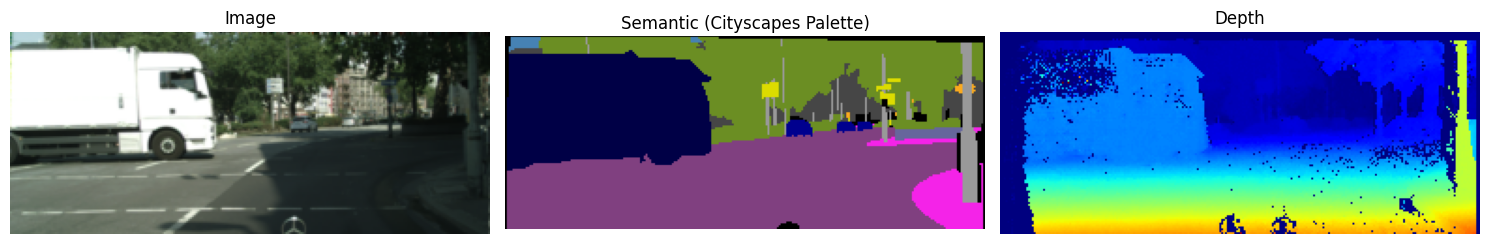

In [16]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# === Cityscapes Color Palette Based on Train ID ===
cityscapes_trainid_to_color = {
    0:  (128, 64, 128),     # road
    1:  (244, 35, 232),     # sidewalk
    2:  (70, 70, 70),       # building
    3:  (102, 102, 156),    # wall
    4:  (190, 153, 153),    # fence
    5:  (153, 153, 153),    # pole
    6:  (250, 170, 30),     # traffic light
    7:  (220, 220, 0),      # traffic sign
    8:  (107, 142, 35),     # vegetation
    9:  (152, 251, 152),    # terrain
    10: (70, 130, 180),     # sky
    11: (220, 20, 60),      # person
    12: (255, 0, 0),        # rider
    13: (0, 0, 142),        # car
    14: (0, 0, 70),         # truck
    15: (0, 60, 100),       # bus
    16: (0, 80, 100),       # train
    17: (0, 0, 230),        # motorcycle
    18: (119, 11, 32),      # bicycle
    19: (0, 0, 142),        # license plate (ignoreInEval)
    20: (0, 0, 0)           # unlabeled / ignored
}

# === Function to map semantic mask to RGB image ===
def decode_semantic_mask(sem_mask, palette):
    """
    Convert a 2D semantic mask (with train IDs) to a color RGB image.
    """
    h, w = sem_mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for train_id, color in palette.items():
        color_mask[sem_mask == train_id] = color
    return color_mask

# === Load and crop sample ===
img_dict = test_set.__getitem__(21)
img = img_dict['image'][:, :-20]
sem = img_dict['semantic'][:-25, :]
depth = img_dict['depth'][:, :-20]

print("Shapes:", img.shape, sem.shape, depth.shape)

# === Decode semantic mask ===
sem_np = sem.numpy() if isinstance(sem, torch.Tensor) else sem
sem_rgb = decode_semantic_mask(sem_np, cityscapes_trainid_to_color)

# === Visualization ===
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Image')
plt.imshow(img.permute(1, 2, 0))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Semantic (Cityscapes Palette)')
plt.imshow(sem_rgb)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Depth')
plt.imshow(depth.permute(1, 2, 0), cmap='jet')
plt.axis('off')

plt.tight_layout()
plt.show()


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
from torch.nn.init import _calculate_fan_in_and_fan_out
from timm.layers import to_2tuple, trunc_normal_
import os
import torchvision.utils as utils
import torch.utils.data as data
from torch.utils.data import DataLoader
import glob
from torchvision.transforms import ToTensor, Normalize, Compose, ToPILImage
from torchvision.models import vgg16
from torch.utils.data import Dataset
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from random import randrange
import time
from math import log10
from skimage import measure
import ipywidgets as widgets
from IPython.display import display
from torch.nn.init import trunc_normal_
import matplotlib.pyplot as plt

## RevisedLayerNorm

In [18]:
class RevisedLayerNorm(nn.Module):
    """Revised LayerNorm"""
    def __init__(self, embed_dim, epsilon=1e-5, detach_gradient=False):
        super(RevisedLayerNorm, self).__init__()
        self.epsilon = epsilon
        self.detach_gradient = detach_gradient

        self.scale = nn.Parameter(torch.ones((1, embed_dim, 1, 1)))
        self.shift = nn.Parameter(torch.zeros((1, embed_dim, 1, 1)))

        self.scale_mlp = nn.Conv2d(1, embed_dim, 1)
        self.shift_mlp = nn.Conv2d(1, embed_dim, 1)

        trunc_normal_(self.scale_mlp.weight, std=.02)
        nn.init.constant_(self.scale_mlp.bias, 1)

        trunc_normal_(self.shift_mlp.weight, std=.02)
        nn.init.constant_(self.shift_mlp.bias, 0)

    def forward(self, input_tensor):
        mean_value = torch.mean(input_tensor, dim=(1, 2, 3), keepdim=True)
        std_value = torch.sqrt((input_tensor - mean_value).pow(2).mean(dim=(1, 2, 3), keepdim=True) + self.epsilon)

        normalized_tensor = (input_tensor - mean_value) / std_value

        if self.detach_gradient:
            rescale, rebias = self.scale_mlp(std_value.detach()), self.shift_mlp(mean_value.detach())
        else:
            rescale, rebias = self.scale_mlp(std_value), self.shift_mlp(mean_value)

        output = normalized_tensor * self.scale + self.shift
        return output, rescale, rebias



In [19]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, depth, input_channels, hidden_channels=None, output_channels=None):
        super().__init__()
        output_channels = output_channels or input_channels
        hidden_channels = hidden_channels or input_channels

        self.depth = depth

        self.mlp_layers = nn.Sequential(
            nn.Conv2d(input_channels, hidden_channels, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_channels, output_channels, kernel_size=1)
        )

        self.apply(self._initialize_weights)

    def _initialize_weights(self, layer):
        if isinstance(layer, nn.Conv2d):
            gain = (8 * self.depth) ** (-1 / 4)
            fan_in, fan_out = torch.nn.init._calculate_fan_in_and_fan_out(layer.weight)
            std = gain * math.sqrt(2.0 / float(fan_in + fan_out))
            trunc_normal_(layer.weight, std=std)
            if layer.bias is not None:
                nn.init.constant_(layer.bias, 0)

    def forward(self, x):
        return self.mlp_layers(x)


def partition_into_windows(tensor, window_size):
    """Splits the input tensor into non-overlapping windows."""
    batch_size, height, width, channels = tensor.shape
    assert height % window_size == 0 and width % window_size == 0, "Height and width must be divisible by window_size"

    tensor = tensor.view(
        batch_size, height // window_size, window_size, width // window_size, window_size, channels
    )
    windows = tensor.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size**2, channels)
    return windows


def merge_windows(windows, window_size, height, width):
    """Reconstructs the original tensor from partitioned windows."""
    batch_size = windows.shape[0] // ((height * width) // (window_size**2))
    tensor = windows.view(
        batch_size, height // window_size, width // window_size, window_size, window_size, -1
    )
    tensor = tensor.permute(0, 1, 3, 2, 4, 5).contiguous().view(batch_size, height, width, -1)
    return tensor


### test

In [20]:
import torch

# Initialize the MultiLayerPerceptron with sample parameters
depth = 4
input_channels = 64
hidden_channels = 128
output_channels = 64

mlp = MultiLayerPerceptron(depth, input_channels, hidden_channels, output_channels)

# Create a random tensor to test MLP (batch_size=2, channels=64, height=16, width=16)
input_tensor = torch.randn(2, 64, 16, 16)
output_tensor = mlp(input_tensor)

# Check output shape
mlp_output_shape = output_tensor.shape

# Test window partition and merging
batch_size, height, width, channels = 2, 16, 16, 64
window_size = 4

# Create a random tensor for window functions (B, H, W, C) format
input_window_tensor = torch.randn(batch_size, height, width, channels)

# Apply partitioning and merging
windows = partition_into_windows(input_window_tensor, window_size)
reconstructed_tensor = merge_windows(windows, window_size, height, width)

# Check shapes
windows_shape = windows.shape
reconstructed_shape = reconstructed_tensor.shape

# Validate if the reconstruction matches the original input shape
is_shape_correct = reconstructed_shape == input_window_tensor.shape

# Output results
mlp_output_shape, windows_shape, reconstructed_shape, is_shape_correct


(torch.Size([2, 64, 16, 16]),
 torch.Size([32, 16, 64]),
 torch.Size([2, 16, 16, 64]),
 True)

In [21]:
class LocalWindowAttention(nn.Module):
    def __init__(self, embed_dim, window_size, num_heads):
        """Self-attention mechanism within local windows."""
        super().__init__()
        self.embed_dim = embed_dim
        self.window_size = window_size  # (height, width)
        self.num_heads = num_heads
        head_dim = embed_dim // num_heads
        self.scaling_factor = head_dim ** -0.5  # Scaled dot-product attention

        # Compute and store relative positional encodings
        relative_positional_encodings = compute_log_relative_positions(self.window_size)
        self.register_buffer("relative_positional_encodings", relative_positional_encodings)

        # Learnable transformation of relative position embeddings
        self.relative_mlp = nn.Sequential(
            nn.Linear(2, 256, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_heads, bias=True)
        )

        self.attention_softmax = nn.Softmax(dim=-1)

    def forward(self, qkv):
        """Computes attention scores and applies self-attention within a window."""
        batch_size, num_tokens, _ = qkv.shape

        # Reshape qkv into separate query, key, and value tensors
        qkv = qkv.reshape(batch_size, num_tokens, 3, self.num_heads, self.embed_dim // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # Unpacking query, key, and value

        # Scale query for stable attention computation
        q = q * self.scaling_factor
        attention_scores = q @ k.transpose(-2, -1)

        # Compute relative position bias
        relative_bias = self.relative_mlp(self.relative_positional_encodings)
        relative_bias = relative_bias.permute(2, 0, 1).contiguous()  # Shape: (num_heads, window_size², window_size²)
        attention_scores = attention_scores + relative_bias.unsqueeze(0)

        # Apply softmax and compute weighted values
        attention_weights = self.attention_softmax(attention_scores)
        output = (attention_weights @ v).transpose(1, 2).reshape(batch_size, num_tokens, self.embed_dim)

        return output

In [22]:
def compute_log_relative_positions(window_size):
    """Computes log-scaled relative position embeddings for a given window size."""
    coord_range = torch.arange(window_size)

    # Create coordinate grid
    coord_grid = torch.stack(torch.meshgrid([coord_range, coord_range]))  # Shape: (2, window_size, window_size)
    
    # Flatten coordinates
    flattened_coords = torch.flatten(coord_grid, 1)  # Shape: (2, window_size * window_size)

    # Compute relative positions
    relative_positions = flattened_coords[:, :, None] - flattened_coords[:, None, :]  # Shape: (2, window_size^2, window_size^2)

    # Format and apply log transformation
    relative_positions = relative_positions.permute(1, 2, 0).contiguous()  # Shape: (window_size^2, window_size^2, 2)
    log_relative_positions = torch.sign(relative_positions) * torch.log(1. + relative_positions.abs())

    return log_relative_positions


In [23]:
class AdaptiveAttention(nn.Module):
    def __init__(self, network_depth, embed_dim, num_heads, window_size, shift_size, enable_attention=False, conv_mode=None):
        """Hybrid attention-convolution module with optional window-based attention."""
        super().__init__()
        self.embed_dim = embed_dim
        self.head_dim = embed_dim // num_heads
        self.num_heads = num_heads

        self.window_size = window_size
        self.shift_size = shift_size

        self.network_depth = network_depth
        self.enable_attention = enable_attention
        self.conv_mode = conv_mode

        # Define convolutional processing based on mode
        if self.conv_mode == 'Conv':
            self.conv_layer = nn.Sequential(
                nn.Conv2d(embed_dim, embed_dim, kernel_size=3, padding=1, padding_mode='reflect'),
                nn.ReLU(inplace=True),
                nn.Conv2d(embed_dim, embed_dim, kernel_size=3, padding=1, padding_mode='reflect')
            )

        if self.conv_mode == 'DWConv':
            self.conv_layer = nn.Conv2d(embed_dim, embed_dim, kernel_size=5, padding=2, groups=embed_dim, padding_mode='reflect')

        if self.conv_mode == 'DWConv' or self.enable_attention:
            self.value_projection = nn.Conv2d(embed_dim, embed_dim, 1)
            self.output_projection = nn.Conv2d(embed_dim, embed_dim, 1)

        if self.enable_attention:
            self.query_key_projection = nn.Conv2d(embed_dim, embed_dim * 2, 1)
            self.window_attention = LocalWindowAttention(embed_dim, window_size, num_heads)

        self.apply(self._initialize_weights)

    def _initialize_weights(self, module):
        """Custom weight initialization."""
        if isinstance(module, nn.Conv2d):
            weight_shape = module.weight.shape

            if weight_shape[0] == self.embed_dim * 2:  # Query-Key projection
                fan_in, fan_out = _calculate_fan_in_and_fan_out(module.weight)
                std = math.sqrt(2.0 / float(fan_in + fan_out))
                trunc_normal_(module.weight, std=std)
            else:
                gain = (8 * self.network_depth) ** (-1/4)
                fan_in, fan_out = _calculate_fan_in_and_fan_out(module.weight)
                std = gain * math.sqrt(2.0 / float(fan_in + fan_out))
                trunc_normal_(module.weight, std=std)

            if module.bias is not None:
                nn.init.constant_(module.bias, 0)

    def pad_for_window_processing(self, x, shift=False):
        """Pads the input tensor to fit window processing requirements."""
        _, _, height, width = x.size()
        pad_h = (self.window_size - height % self.window_size) % self.window_size
        pad_w = (self.window_size - width % self.window_size) % self.window_size

        if shift:
            x = F.pad(x, (self.shift_size, (self.window_size - self.shift_size + pad_w) % self.window_size,
                          self.shift_size, (self.window_size - self.shift_size + pad_h) % self.window_size), mode='reflect')
        else:
            x = F.pad(x, (0, pad_w, 0, pad_h), 'reflect')
        return x

    def forward(self, x):
        """Computes the output with optional attention and convolution."""
        batch_size, channels, height, width = x.shape

        if self.conv_mode == 'DWConv' or self.enable_attention:
            v_proj = self.value_projection(x)

        if self.enable_attention:
            qk_proj = self.query_key_projection(x)
            qkv = torch.cat([qk_proj, v_proj], dim=1)

            # Apply padding for shifted window processing
            padded_qkv = self.pad_for_window_processing(qkv, self.shift_size > 0)
            padded_height, padded_width = padded_qkv.shape[2:]

            # Partition into windows
            padded_qkv = padded_qkv.permute(0, 2, 3, 1)
            qkv_windows = partition_into_windows(padded_qkv, self.window_size)  # (num_windows * batch, window_size², channels)

            # Apply window-based attention
            attn_windows = self.window_attention(qkv_windows)

            # Merge back to original spatial dimensions
            merged_output = merge_windows(attn_windows, self.window_size, padded_height, padded_width)

            # Reverse the cyclic shift
            attn_output = merged_output[:, self.shift_size:(self.shift_size + height), self.shift_size:(self.shift_size + width), :]
            attn_output = attn_output.permute(0, 3, 1, 2)

            if self.conv_mode in ['Conv', 'DWConv']:
                conv_output = self.conv_layer(v_proj)
                output = self.output_projection(conv_output + attn_output)
            else:
                output = self.output_projection(attn_output)

        else:
            if self.conv_mode == 'Conv':
                output = self.conv_layer(x)  # No attention, using convolution only
            elif self.conv_mode == 'DWConv':
                output = self.output_projection(self.conv_layer(v_proj))

        return output

In [24]:
class VisionTransformerBlock(nn.Module):
    def __init__(self, network_depth, embed_dim, num_heads, mlp_ratio=4.0,
                 norm_layer=nn.LayerNorm, enable_mlp_norm=False,
                 window_size=8, shift_size=0, enable_attention=True, conv_mode=None):
        """
        A transformer block that includes attention (optional) and MLP layers.
        """
        super().__init__()
        self.enable_attention = enable_attention
        self.enable_mlp_norm = enable_mlp_norm

        self.pre_norm = norm_layer(embed_dim) if enable_attention else nn.Identity()
        self.attention_layer = AdaptiveAttention(
            network_depth, embed_dim, num_heads=num_heads, window_size=window_size,
            shift_size=shift_size, enable_attention=enable_attention, conv_mode=conv_mode
        )

        self.post_norm = norm_layer(embed_dim) if enable_attention and enable_mlp_norm else nn.Identity()
        self.mlp_layer = MultiLayerPerceptron(network_depth, embed_dim, hidden_channels=int(embed_dim * mlp_ratio))

    def forward(self, x):
        """
        Forward pass through the transformer block.
        """
        residual = x
        if self.enable_attention:
            x, rescale, rebias = self.pre_norm(x)
        x = self.attention_layer(x)
        if self.enable_attention:
            x = x * rescale + rebias
        x = residual + x  # Residual connection

        residual = x
        if self.enable_attention and self.enable_mlp_norm:
            x, rescale, rebias = self.post_norm(x)
        x = self.mlp_layer(x)
        if self.enable_attention and self.enable_mlp_norm:
            x = x * rescale + rebias
        x = residual + x  # Residual connection

        return x


class TransformerStage(nn.Module):
    def __init__(self, network_depth, embed_dim, num_layers, num_heads, mlp_ratio=4.0,
                 norm_layer=nn.LayerNorm, window_size=8,
                 attention_ratio=0.0, attention_placement='last', conv_mode=None):
        """
        A stage of transformer blocks with configurable attention placement.
        """
        super().__init__()
        self.embed_dim = embed_dim
        self.num_layers = num_layers

        attention_layers = int(attention_ratio * num_layers)

        if attention_placement == 'last':
            enable_attentions = [i >= num_layers - attention_layers for i in range(num_layers)]
        elif attention_placement == 'first':
            enable_attentions = [i < attention_layers for i in range(num_layers)]
        elif attention_placement == 'middle':
            enable_attentions = [
                (i >= (num_layers - attention_layers) // 2) and (i < (num_layers + attention_layers) // 2)
                for i in range(num_layers)
            ]

        # Build transformer blocks
        self.blocks = nn.ModuleList([
            VisionTransformerBlock(
                network_depth=network_depth,
                embed_dim=embed_dim,
                num_heads=num_heads,
                mlp_ratio=mlp_ratio,
                norm_layer=norm_layer,
                window_size=window_size,
                shift_size=0 if (i % 2 == 0) else window_size // 2,
                enable_attention=enable_attentions[i],
                conv_mode=conv_mode
            ) for i in range(num_layers)
        ])

    def forward(self, x):
        """
        Forward pass through the transformer stage.
        """
        for block in self.blocks:
            x = block(x)
        return x


In [25]:
class PatchEmbedding(nn.Module):
    def __init__(self, patch_size=4, input_channels=3, embedding_dim=96, kernel_size=None):
        """
        Patch embedding module that projects input images into token embeddings.
        """
        super().__init__()
        self.input_channels = input_channels
        self.embedding_dim = embedding_dim

        if kernel_size is None:
            kernel_size = patch_size

        self.projection = nn.Conv2d(
            input_channels, embedding_dim, kernel_size=kernel_size, stride=patch_size,
            padding=(kernel_size - patch_size + 1) // 2, padding_mode='reflect'
        )

    def forward(self, x):
        """
        Forward pass to generate patch embeddings.
        """
        return self.projection(x)


class PatchReconstruction(nn.Module):
    def __init__(self, patch_size=4, output_channels=3, embedding_dim=96, kernel_size=None):
        """
        Patch reconstruction module that converts token embeddings back to image patches.
        """
        super().__init__()
        self.output_channels = output_channels
        self.embedding_dim = embedding_dim

        if kernel_size is None:
            kernel_size = 1

        self.projection = nn.Sequential(
            nn.Conv2d(
                embedding_dim, output_channels * patch_size ** 2, kernel_size=kernel_size,
                padding=kernel_size // 2, padding_mode='reflect'
            ),
            nn.PixelShuffle(patch_size)
        )

    def forward(self, x):
        """
        Forward pass to reconstruct image from embeddings.
        """
        return self.projection(x)


In [26]:
class SelectiveKernelFusion(nn.Module):
    def __init__(self, channels, num_branches=2, reduction_ratio=8):
        """
        Selective Kernel Fusion (SKFusion) module for adaptive feature selection.

        Args:
            channels (int): Number of input channels.
            num_branches (int): Number of feature branches to fuse.
            reduction_ratio (int): Reduction ratio for the attention mechanism.
        """
        super().__init__()
        
        self.num_branches = num_branches
        reduced_channels = max(int(channels / reduction_ratio), 4)
        
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.channel_attention = nn.Sequential(
            nn.Conv2d(channels, reduced_channels, kernel_size=1, bias=False), 
            nn.ReLU(),
            nn.Conv2d(reduced_channels, channels * num_branches, kernel_size=1, bias=False)
        )
        
        self.softmax = nn.Softmax(dim=1)

    def forward(self, feature_maps):
        """
        Forward pass for selective kernel fusion.

        Args:
            feature_maps (list of tensors): A list of feature maps to be fused.

        Returns:
            torch.Tensor: The adaptively fused feature map.
        """
        batch_size, channels, height, width = feature_maps[0].shape
        
        # Concatenate feature maps along a new dimension (num_branches)
        stacked_features = torch.cat(feature_maps, dim=1).view(batch_size, self.num_branches, channels, height, width)
        
        # Compute attention weights
        aggregated_features = torch.sum(stacked_features, dim=1)
        attention_weights = self.channel_attention(self.global_avg_pool(aggregated_features))
        attention_weights = self.softmax(attention_weights.view(batch_size, self.num_branches, channels, 1, 1))

        # Weighted sum of input feature maps
        fused_output = torch.sum(stacked_features * attention_weights, dim=1)
        return fused_output


In [27]:
class DehazingTransformer(nn.Module):
    def __init__(self, input_channels=3, output_channels=4, window_size=8,
                 embed_dims=[24, 48, 96, 48, 24],
                 mlp_ratios=[2., 4., 4., 2., 2.],
                 layer_depths=[16, 16, 16, 8, 8],
                 num_heads=[2, 4, 6, 1, 1],
                 attention_ratios=[1/4, 1/2, 3/4, 0, 0],
                 conv_types=['DWConv', 'DWConv', 'DWConv', 'DWConv', 'DWConv'],
                 norm_layers=[RevisedLayerNorm, RevisedLayerNorm, RevisedLayerNorm, RevisedLayerNorm, RevisedLayerNorm]):
        super().__init__()

        # Patch embedding settings
        self.patch_size = 4
        self.window_size = window_size

        # Initial patch embedding
        self.patch_embed = PatchEmbedding(
            patch_size=1, input_channels=input_channels, embedding_dim=embed_dims[0], kernel_size=3)

        # Backbone layers
        self.encoder_stage1 = TransformerStage(
            network_depth=sum(layer_depths),
            embed_dim=embed_dims[0],
            num_layers=layer_depths[0],
            num_heads=num_heads[0],
            mlp_ratio=mlp_ratios[0],
            norm_layer=norm_layers[0],
            window_size=window_size,
            attention_ratio=attention_ratios[0],
            attention_placement='last',
            conv_mode=conv_types[0]
        )
        
        self.downsample1 = PatchEmbedding(
            patch_size=2, input_channels=embed_dims[0], embedding_dim=embed_dims[1]
        )
        
        self.skip_connection1 = nn.Conv2d(embed_dims[0], embed_dims[0], 1)
        
        self.encoder_stage2 = TransformerStage(
            network_depth=sum(layer_depths),
            embed_dim=embed_dims[1],
            num_layers=layer_depths[1],
            num_heads=num_heads[1],
            mlp_ratio=mlp_ratios[1],
            norm_layer=norm_layers[1],
            window_size=window_size,
            attention_ratio=attention_ratios[1],
            attention_placement='last',
            conv_mode=conv_types[1]
        )
        
        self.downsample2 = PatchEmbedding(
            patch_size=2, input_channels=embed_dims[1], embedding_dim=embed_dims[2]
        )
        
        self.skip_connection2 = nn.Conv2d(embed_dims[1], embed_dims[1], 1)
        
        self.encoder_stage3 = TransformerStage(
            network_depth=sum(layer_depths),
            embed_dim=embed_dims[2],
            num_layers=layer_depths[2],
            num_heads=num_heads[2],
            mlp_ratio=mlp_ratios[2],
            norm_layer=norm_layers[2],
            window_size=window_size,
            attention_ratio=attention_ratios[2],
            attention_placement='last',
            conv_mode=conv_types[2]
        )
        
        self.upsample1 = PatchReconstruction(
            patch_size=2, output_channels=embed_dims[3], embedding_dim=embed_dims[2]
        )
        
        assert embed_dims[1] == embed_dims[3]
        self.fusion_layer1 = SelectiveKernelFusion(embed_dims[3])
        
        self.decoder_stage1 = TransformerStage(
            network_depth=sum(layer_depths),
            embed_dim=embed_dims[3],
            num_layers=layer_depths[3],
            num_heads=num_heads[3],
            mlp_ratio=mlp_ratios[3],
            norm_layer=norm_layers[3],
            window_size=window_size,
            attention_ratio=attention_ratios[3],
            attention_placement='last',
            conv_mode=conv_types[3]
        )
        
        self.upsample2 = PatchReconstruction(
            patch_size=2, output_channels=embed_dims[4], embedding_dim=embed_dims[3]
        )
        
        assert embed_dims[0] == embed_dims[4]
        self.fusion_layer2 = SelectiveKernelFusion(embed_dims[4])
        
        self.decoder_stage2 = TransformerStage(
            network_depth=sum(layer_depths),
            embed_dim=embed_dims[4],
            num_layers=layer_depths[4],
            num_heads=num_heads[4],
            mlp_ratio=mlp_ratios[4],
            norm_layer=norm_layers[4],
            window_size=window_size,
            attention_ratio=attention_ratios[4],
            attention_placement='last',
            conv_mode=conv_types[4]
        )

        # Final patch reconstruction
        self.patch_reconstruction = PatchReconstruction(
            patch_size=1, output_channels=output_channels, embedding_dim=embed_dims[4], kernel_size=3)

    def adjust_image_size(self, x):
        # Ensures the input image size is compatible with the patch size
        _, _, height, width = x.size()
        pad_height = (self.patch_size - height % self.patch_size) % self.patch_size
        pad_width = (self.patch_size - width % self.patch_size) % self.patch_size
        x = F.pad(x, (0, pad_width, 0, pad_height), 'reflect')
        return x

    def extract_features(self, x):
        x = self.patch_embed(x)
        x = self.encoder_stage1(x)
        skip1 = x

        x = self.downsample1(x)
        x = self.encoder_stage2(x)
        skip2 = x

        x = self.downsample2(x)
        x = self.encoder_stage3(x)
        x = self.upsample1(x)

        x = self.fusion_layer1([x, self.skip_connection2(skip2)]) + x
        x = self.decoder_stage1(x)
        x = self.upsample2(x)

        x = self.fusion_layer2([x, self.skip_connection1(skip1)]) + x
        x = self.decoder_stage2(x)
        x = self.patch_reconstruction(x)
        return x

    def forward(self, x):
        original_height, original_width = x.shape[2:]
        x = self.adjust_image_size(x)

        features = self.extract_features(x)
        transmission_map, atmospheric_light = torch.split(features, (1, 3), dim=1)

        # Dehazing formula: I = J * t + A * (1 - t)
        x = transmission_map * x - atmospheric_light + x
        x = x[:, :, :original_height, :original_width]
        return x

In [28]:
def build_dehazing_transformer():
    return DehazingTransformer(
        embed_dims=[24, 48, 96, 48, 24],
        mlp_ratios=[2., 4., 4., 2., 2.],
        layer_depths=[12, 12, 12, 6, 6],
        num_heads=[2, 4, 6, 1, 1],
        attention_ratios=[1/4, 1/2, 3/4, 0, 0],
        conv_types=['Conv', 'Conv', 'Conv', 'Conv', 'Conv']
    )

In [29]:
class ConvolutionalGuidedFilter(nn.Module):
    def __init__(self, radius=1, norm_layer=nn.BatchNorm2d, conv_kernel_size: int = 1):
        super(ConvolutionalGuidedFilter, self).__init__()

        self.box_filter = nn.Conv2d(
            3, 3, kernel_size=3, padding=radius, dilation=radius, bias=False, groups=3
        )
        self.conv_a = nn.Sequential(
            nn.Conv2d(
                6,
                32,
                kernel_size=conv_kernel_size,
                padding=conv_kernel_size // 2,
                bias=False,
            ),
            norm_layer(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                32,
                32,
                kernel_size=conv_kernel_size,
                padding=conv_kernel_size // 2,
                bias=False,
            ),
            norm_layer(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                32,
                3,
                kernel_size=conv_kernel_size,
                padding=conv_kernel_size // 2,
                bias=False,
            ),
        )
        self.box_filter.weight.data[...] = 1.0

    def forward(self, x_low_res, y_low_res, x_high_res):
        _, _, h_lr, w_lr = x_low_res.size()
        _, _, h_hr, w_hr = x_high_res.size()

        N = self.box_filter(x_low_res.data.new().resize_((1, 3, h_lr, w_lr)).fill_(1.0))
        ## mean_x
        mean_x = self.box_filter(x_low_res) / N
        ## mean_y
        mean_y = self.box_filter(y_low_res) / N
        ## cov_xy
        cov_xy = self.box_filter(x_low_res * y_low_res) / N - mean_x * mean_y
        ## var_x
        var_x = self.box_filter(x_low_res * x_low_res) / N - mean_x * mean_x

        ## A
        A = self.conv_a(torch.cat([cov_xy, var_x], dim=1))
        ## b
        b = mean_y - A * mean_x

        ## mean_A; mean_b
        mean_A = F.interpolate(A, (h_hr, w_hr), mode="bilinear", align_corners=True)
        mean_b = F.interpolate(b, (h_hr, w_hr), mode="bilinear", align_corners=True)

        return mean_A * x_high_res + mean_b

In [30]:
class PixelAttentionLayer(nn.Module):
    def __init__(self, channels):
        super(PixelAttentionLayer, self).__init__()
        self.attention = nn.Sequential(
                nn.Conv2d(channels, channels // 8, kernel_size=1, padding=0, bias=True),
                nn.ReLU(inplace=True),
                nn.Conv2d(channels // 8, 1, kernel_size=1, padding=0, bias=True),
                nn.Sigmoid()
        )
    
    def forward(self, x):
        attention_map = self.attention(x)
        return x * attention_map

class ChannelAttentionLayer(nn.Module):
    def __init__(self, channels):
        super(ChannelAttentionLayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.attention = nn.Sequential(
                nn.Conv2d(channels, channels // 8, kernel_size=1, padding=0, bias=True),
                nn.ReLU(inplace=True),
                nn.Conv2d(channels // 8, channels, kernel_size=1, padding=0, bias=True),
                nn.Sigmoid()
        )

    def forward(self, x):
        pooled = self.avg_pool(x)
        attention_map = self.attention(pooled)
        return x * attention_map


In [31]:
class SuperResolutionDilationBlock(nn.Module):
    def __init__(self, in_channels, num_dense_layers, growth_rate):
        super(SuperResolutionDilationBlock, self).__init__()

        self.split_channels = in_channels // 4
        kernel_size = 3

        # Dilated convolutions with increasing dilation rates
        self.conv1 = nn.Conv2d(self.split_channels, self.split_channels, kernel_size=kernel_size, padding=1, dilation=1)
        self.conv2 = nn.Conv2d(self.split_channels * 2, self.split_channels, kernel_size=kernel_size, padding=2, dilation=2)
        self.conv3 = nn.Conv2d(self.split_channels * 3, self.split_channels, kernel_size=kernel_size, padding=4, dilation=4)
        self.conv4 = nn.Conv2d(self.split_channels * 4, self.split_channels, kernel_size=kernel_size, padding=8, dilation=8)

        # Attention mechanisms
        self.channel_attention = ChannelAttentionLayer(in_channels)
        self.pixel_attention = PixelAttentionLayer(in_channels)

        # Final 1x1 convolution for feature fusion
        self.conv_1x1 = nn.Conv2d(in_channels, in_channels, kernel_size=1, padding=0)

    def forward(self, x):
        # Split input into 4 equal parts along channel dimension
        split_features = torch.split(x, self.split_channels, dim=1)

        x0 = F.relu(self.conv1(split_features[0]))
        tmp = torch.cat((split_features[1], x0), dim=1)
        x1 = F.relu(self.conv2(tmp))

        tmp = torch.cat((split_features[2], x0, x1), dim=1)
        x2 = F.relu(self.conv3(tmp))

        tmp = torch.cat((split_features[3], x0, x1, x2), dim=1)
        x3 = F.relu(self.conv4(tmp))

        # Concatenate all outputs
        merged_features = torch.cat((x0, x1, x2, x3), dim=1)

        # Apply 1x1 convolution for feature refinement
        out = self.conv_1x1(merged_features)

        # Apply attention mechanisms
        out = self.channel_attention(out)
        out = self.pixel_attention(out)

        # Residual connection
        return out + x

In [32]:
class AdaptiveInstanceNormalization(nn.Module):
    def __init__(self, num_channels):
        super(AdaptiveInstanceNormalization, self).__init__()

        # Learnable scaling factors
        self.scale_x = nn.Parameter(torch.tensor(1.0))  # Identity scaling
        self.scale_norm = nn.Parameter(torch.tensor(0.0))  # Initially no effect

        # Instance normalization layer with affine transformation enabled
        self.instance_norm = nn.InstanceNorm2d(num_channels, momentum=0.999, eps=0.001, affine=True)

    def forward(self, x):
        normalized_x = self.instance_norm(x)
        return self.scale_x * x + self.scale_norm * normalized_x

In [33]:
class DeepGuidedNetwork(nn.Module):
    def __init__(self, radius=1):
        super().__init__()

        # Adaptive Normalization for Guided Filtering
        norm = AdaptiveInstanceNormalization
        kernel_size = 3
        depth_rate = 16
        in_channels = 3
        num_dense_layer = 4
        growth_rate = 16

        # Initial convolution layers
        self.conv_in = nn.Conv2d(in_channels, depth_rate, kernel_size=kernel_size, padding=(kernel_size - 1) // 2)
        self.conv_out = nn.Conv2d(depth_rate, in_channels, kernel_size=kernel_size, padding=(kernel_size - 1) // 2)

        # Residual Dense Blocks (RDBs)
        self.rdb1 = SuperResolutionDilationBlock(depth_rate, num_dense_layer, growth_rate)
        self.rdb2 = SuperResolutionDilationBlock(depth_rate, num_dense_layer, growth_rate)
        self.rdb3 = SuperResolutionDilationBlock(depth_rate, num_dense_layer, growth_rate)
        self.rdb4 = SuperResolutionDilationBlock(depth_rate, num_dense_layer, growth_rate)

        # Guided Filter & Dehazing Transformer
        self.guided_filter = ConvolutionalGuidedFilter(radius, norm_layer=norm)
        self.dehaze_network = build_dehazing_transformer()

        # Downsampling & Upsampling Layers
        self.downsample = nn.Upsample(scale_factor=0.5, mode="bilinear", align_corners=True)
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)

    def forward(self, x_hr):
        # Low-resolution processing
        x_lr = self.downsample(x_hr)

        # Detail extraction through Residual Dense Blocks
        y_features = self.conv_in(x_lr)
        y_features = self.rdb1(y_features)
        y_features = self.rdb2(y_features)
        y_features = self.rdb3(y_features)
        y_features = self.rdb4(y_features)
        y_detail = self.conv_out(y_features)

        # Base image estimation using DehazeFormer
        y_base = self.dehaze_network(x_lr)

        # Combining base and details    
        y_lr = y_base + y_detail
        y_base_hr = self.upsample(y_base)

        # Final guided filtering refinement
        refined_output = self.guided_filter(x_lr, y_lr, x_hr)
        
        return refined_output, y_base_hr


In [34]:
def parse_crop_size(crop_size_str):
    try:
        return [int(x.strip()) for x in crop_size_str.split(',')]
    except ValueError:
        raise ValueError(f"Invalid crop size format: '{crop_size_str}'. Expected comma-separated integers.")

In [35]:
import os
import glob
import torch
from torch.utils.data import Dataset
from torchvision.transforms import Compose, ToTensor, Normalize
from PIL import Image, UnidentifiedImageError
from random import randrange

class TrainData(Dataset):
    def __init__(self, crop_size, hazeeffected_images_dir, hazefree_images_dir):
        super().__init__()
        
        # --- Ensure valid file extensions --- #
        valid_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".tiff")
        hazy_data = [
            f for f in glob.glob(os.path.join(hazeeffected_images_dir, "*.*"))
            if f.lower().endswith(valid_extensions)
        ]

        if not hazy_data:
            raise ValueError(f"No valid images found in {hazeeffected_images_dir}")

        self.hazeeffected_images_dir = hazeeffected_images_dir
        self.hazefree_images_dir = hazefree_images_dir

        self.haze_names = []
        self.gt_names = []
        
        for h_image in hazy_data:
            filename = os.path.basename(h_image)
            haze_path = os.path.join(self.hazeeffected_images_dir, filename)
            gt_path = os.path.join(self.hazefree_images_dir, filename)

            if not os.path.exists(gt_path):
                print(f"Warning: Ground-truth missing for {filename}, skipping.")
                continue

            self.haze_names.append(haze_path)
            self.gt_names.append(gt_path)

        if not self.haze_names:
            raise ValueError("No matching ground-truth images found.")

        self.crop_size = crop_size

    def get_images(self, index):
        crop_width, crop_height = self.crop_size
        haze_name = self.haze_names[index]
        gt_name = self.gt_names[index]

        try:
            haze_img = Image.open(haze_name).convert('RGB')
            gt_img = Image.open(gt_name).convert('RGB')
        except UnidentifiedImageError:
            raise ValueError(f"Invalid image format: {haze_name} or {gt_name}")

        width, height = haze_img.size

        # --- Handle small images --- #
        if width < crop_width or height < crop_height:
            raise ValueError(f"Image too small for cropping: {haze_name}")

        # --- Random crop --- #
        x, y = randrange(0, width - crop_width + 1), randrange(0, height - crop_height + 1)
        haze_crop_img = haze_img.crop((x, y, x + crop_width, y + crop_height))
        gt_crop_img = gt_img.crop((x, y, x + crop_width, y + crop_height))

        # --- Transform to tensor --- #
        transform_haze = Compose([ToTensor(), Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        transform_gt = Compose([ToTensor()])
        haze = transform_haze(haze_crop_img)
        gt = transform_gt(gt_crop_img)

        # --- Check channels --- #
        if haze.shape[0] != 3 or gt.shape[0] != 3:
            raise ValueError(f"Invalid image channels: {haze_name}")

        return haze, gt

    def __getitem__(self, index):
        return self.get_images(index)

    def __len__(self):
        return len(self.haze_names)


In [36]:
import os
import glob
import torch
from torch.utils.data import Dataset
from torchvision.transforms import Compose, ToTensor, Normalize
from PIL import Image, UnidentifiedImageError
from random import randrange, shuffle

class HazeDataset(Dataset):
    def __init__(self, crop_size, hazeeffected_images_dir, hazefree_images_dir, split="train", split_ratio=0.8):
        """
        Dataset class for handling both training and validation dynamically.
        
        Args:
            crop_size (tuple): (width, height) of the random crop.
            hazeeffected_images_dir (str): Directory for hazy images.
            hazefree_images_dir (str): Directory for ground-truth images.
            split (str): "train" or "valid" (determines data split).
            split_ratio (float): Percentage of images to use for training (default 80% train, 20% validation).
        """
        super().__init__()
        
        # --- Ensure valid file extensions --- #
        valid_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".tiff")
        hazy_data = [
            f for f in glob.glob(os.path.join(hazeeffected_images_dir, "*.*"))
            if f.lower().endswith(valid_extensions)
        ]

        if not hazy_data:
            raise ValueError(f"No valid images found in {hazeeffected_images_dir}")

        # # --- Sort and shuffle to ensure random split --- #
        hazy_data.sort()
        # shuffle(hazy_data)  

        # --- Split into train and validation --- #
        split_idx = int(len(hazy_data) * split_ratio)
        if split == "train":
            hazy_data = hazy_data[:split_idx]
        else:  # "valid"
            hazy_data = hazy_data[split_idx:]

        self.haze_names = []
        self.gt_names = []
        
        for h_image in hazy_data:
            filename = os.path.basename(h_image)
            haze_path = os.path.join(hazeeffected_images_dir, filename)
            gt_path = os.path.join(hazefree_images_dir, filename)

            if not os.path.exists(gt_path):
                print(f"Warning: Ground-truth missing for {filename}, skipping.")
                continue

            self.haze_names.append(haze_path)
            self.gt_names.append(gt_path)

        if not self.haze_names:
            raise ValueError("No matching ground-truth images found.")

        self.crop_size = crop_size

    def get_images(self, index):
        crop_width, crop_height = self.crop_size
        haze_name = self.haze_names[index]
        gt_name = self.gt_names[index]

        try:
            haze_img = Image.open(haze_name).convert('RGB')
            gt_img = Image.open(gt_name).convert('RGB')
        except UnidentifiedImageError:
            raise ValueError(f"Invalid image format: {haze_name} or {gt_name}")

        width, height = haze_img.size

        # --- Handle small images --- #
        if width < crop_width or height < crop_height:
            raise ValueError(f"Image too small for cropping: {haze_name}")

        # --- Random crop --- #
        x, y = randrange(0, width - crop_width + 1), randrange(0, height - crop_height + 1)
        haze_crop_img = haze_img.crop((x, y, x + crop_width, y + crop_height))
        gt_crop_img = gt_img.crop((x, y, x + crop_width, y + crop_height))

        # --- Transform to tensor --- #
        transform_haze = Compose([ToTensor(), Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        transform_gt = Compose([ToTensor()])
        haze = transform_haze(haze_crop_img)
        gt = transform_gt(gt_crop_img)

        # --- Check channels --- #
        if haze.shape[0] != 3 or gt.shape[0] != 3:
            raise ValueError(f"Invalid image channels: {haze_name}")

        return haze, gt

    def __getitem__(self, index):
        return self.get_images(index)

    def __len__(self):
        return len(self.haze_names)


## Validation

In [37]:
def to_psnr(dehaze, gt):
    """
    Compute PSNR (Peak Signal-to-Noise Ratio) between dehazed and ground truth images.

    Args:
        dehaze (torch.Tensor): Dehazed image tensor (B, C, H, W)
        gt (torch.Tensor): Ground truth image tensor (B, C, H, W)

    Returns:
        List[float]: PSNR values for each image in the batch.
    """
    mse = F.mse_loss(dehaze, gt, reduction='none').mean(dim=[1, 2, 3])  # Compute MSE per image
    intensity_max = 1.0

    # Compute PSNR safely, avoiding division by zero and extreme values
    psnr_list = [10.0 * log10(intensity_max / max(mse_val.item(), 1e-6)) for mse_val in mse]

    return psnr_list


In [38]:
from torchmetrics.image import StructuralSimilarityIndexMeasure

# Define SSIM metric
ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0, reduction='none')

def to_ssim(dehaze: torch.Tensor, gt: torch.Tensor):
    """
    Compute SSIM directly on the GPU using torchmetrics.

    Args:
        dehaze (torch.Tensor): Dehazed image tensor (B, C, H, W)
        gt (torch.Tensor): Ground truth image tensor (B, C, H, W)

    Returns:
        List[float]: SSIM values for each image in the batch.
    """
    ssim_values = ssim_metric(dehaze, gt)  # Shape: [B]
    # print("1",ssim_values)
    # print("2",[ssim_values])
    ssim_values = ssim_values.tolist() 
    # print(type(ssim_values))
    if isinstance(ssim_values, float):  # Correct way to check for a float
        return [ssim_values]  # Convert single float to a list
    return ssim_values  # Otherwise, return as is


In [39]:
# Test with a dummy tensor
dehaze = torch.rand(1, 3, 360, 360)  # Random batch of images
gt = torch.rand(1, 3, 360, 360)  # Random ground truth images

ssim_scores = to_ssim(dehaze, gt)
print(ssim_scores)  # Should print a list of 6 SSIM values

[0.0013979414943605661]


### test

In [40]:
# old_val_psnr, old_val_ssim = validationB(net, val_data_loader, device, category)

In [41]:
# psnr, ssim = validationB(net, val_data_loader, device, category)
# # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# # psnr, ssim = validationB(model, val_loader, device, "indoor", save_tag=True)
# print(f"Validation PSNR: {psnr:.2f}, SSIM: {ssim:.4f}")


In [42]:
execution_env_widget = widgets.Dropdown(options=['local', 'kaggle'], value='local', description='Execution Env:')
display(execution_env_widget)

if os.path.exists('/kaggle'):
    execution_env_widget.value = 'kaggle' 

Dropdown(description='Execution Env:', options=('local', 'kaggle'), value='local')

In [43]:

# --- Create widgets for each hyper-parameter ---
learning_rate_widget = widgets.FloatText(value=1e-4, description='Learning Rate:')
crop_size_widget = widgets.Text(value='128,128', description='Crop Size:')
train_batch_size_widget = widgets.IntText(value=6, description='Train Batch Size:')
version_widget = widgets.IntText(value=0, description='Version:')
growth_rate_widget = widgets.IntText(value=16, description='Growth Rate:')
lambda_loss_widget = widgets.FloatText(value=0.04, description='Lambda Loss:')
val_batch_size_widget = widgets.IntText(value=2, description='Val Batch Size:')
category_widget = widgets.Dropdown(options=['indoor', 'outdoor', 'reside', 'nh'], value='reside', description='Category:')

# --- Display the widgets ---
display(
    learning_rate_widget, crop_size_widget, train_batch_size_widget, version_widget,
    growth_rate_widget, lambda_loss_widget, 
    val_batch_size_widget, category_widget
)

# --- Function to parse crop size ---
def parse_crop_size(crop_size_str):
    return [int(x) for x in crop_size_str.split(',')]

# --- Assign the widget values to variables ---
learning_rate = learning_rate_widget.value
crop_size = parse_crop_size(crop_size_widget.value)
train_batch_size = train_batch_size_widget.value
version = version_widget.value
growth_rate = growth_rate_widget.value
lambda_loss = lambda_loss_widget.value
val_batch_size = val_batch_size_widget.value
category = category_widget.value

execution_env = execution_env_widget.value  # Local or Kaggle


print('\nHyper-parameters set:')
print(f'learning_rate: {learning_rate}')
print(f'crop_size: {crop_size}')
print(f'train_batch_size: {train_batch_size}')
print(f'version: {version}')
print(f'growth_rate: {growth_rate}')
print(f'lambda_loss: {lambda_loss}')
print(f'val_batch_size: {val_batch_size}')
print(f'category: {category}')
print(f'execution_env: {execution_env}')

# --- Set category-specific hyper-parameters ---
if category == 'indoor':
    num_epochs = 1500
    train_data_dir = './data/train/indoor/'
    val_data_dir = './data/test/SOTS/indoor/'
elif category == 'outdoor':
    num_epochs = 10
    train_data_dir = './data/train/outdoor/'
    val_data_dir = './data/test/SOTS/outdoor/'
elif category == 'reside':
    num_epochs = 85
    train_data_dir = 'dataset/RESIDE-6K/train'
    val_data_dir = 'dataset/RESIDE-6K/train'
    test_data_dir = 'dataset/RESIDE-6K/test'
    # train_data_dir = '/kaggle/input/reside6k/RESIDE-6K/train'
    # val_data_dir = '/kaggle/input/reside6k/RESIDE-6K/train'
    # test_data_dir = '/kaggle/input/reside6k/RESIDE-6K/test'
elif category == 'nh':
    num_epochs = 50
    train_data_dir = '/Volumes/S/dev/project/code/Aphase/Dehaze_2/data/NH-Haze_Dense-Haze_datasets/NH-HAZE-T/train/hazy'
    val_data_dir = '/Volumes/S/dev/project/code/Aphase/Dehaze_2/data/NH-Haze_Dense-Haze_datasets/NH-HAZE-T/train/GT'
else:
    raise Exception('Wrong image category. Set it to indoor or outdoor for RESIDE dataset.')

# --- Adjust paths based on execution environment ---
# if execution_env == 'kaggle':
    # train_data_dir = '/kaggle/input/reside-dataset/' + train_data_dir.strip('./')
    # val_data_dir = '/kaggle/input/reside-dataset/' + val_data_dir.strip('./')
    # train_data_dir = '/kaggle/input/nh-dense-haze/NH-HAZE-T/NH-HAZE-T'
    # val_data_dir = '/kaggle/input/nh-dense-haze/NH-HAZE-V/NH-HAZE-V' 
    # train_data_dir = '/kaggle/input/o-haze/O-HAZY/hazy'
    # val_data_dir = '/kaggle/input/o-haze/O-HAZY/GT' 
print('\nFinal dataset paths:')
print(f'Training directory: {train_data_dir}')
print(f'Validation directory: {val_data_dir}')
print(f'Number of epochs: {num_epochs}')


FloatText(value=0.0001, description='Learning Rate:')

Text(value='128,128', description='Crop Size:')

IntText(value=6, description='Train Batch Size:')

IntText(value=0, description='Version:')

IntText(value=16, description='Growth Rate:')

FloatText(value=0.04, description='Lambda Loss:')

IntText(value=2, description='Val Batch Size:')

Dropdown(description='Category:', index=2, options=('indoor', 'outdoor', 'reside', 'nh'), value='reside')


Hyper-parameters set:
learning_rate: 0.0001
crop_size: [128, 128]
train_batch_size: 6
version: 0
growth_rate: 16
lambda_loss: 0.04
val_batch_size: 2
category: reside
execution_env: local

Final dataset paths:
Training directory: dataset/RESIDE-6K/train
Validation directory: dataset/RESIDE-6K/train
Number of epochs: 85


In [44]:
# hazeeffected_images_dir_train = f"{train_data_dir}/IN"
hazeeffected_images_dir_train = f"{train_data_dir}/hazy"
hazefree_images_dir_train = f"{train_data_dir}/GT"

# hazeeffected_images_dir_valid = f"{val_data_dir}/IN"
hazeeffected_images_dir_valid = f"{val_data_dir}/hazy"
hazefree_images_dir_valid = f"{val_data_dir}/GT"

In [45]:
# import os
# import glob
# import shutil

# hazeeffected_images_dir_train = f"{train_data_dir}/IN"
# hazefree_images_dir_train = f"{train_data_dir}/GT"

# hazeeffected_images_dir_valid = f"{val_data_dir}/IN"
# hazefree_images_dir_valid = f"{val_data_dir}/GT"

# # Create validation directories if they don't exist
# os.makedirs(hazeeffected_images_dir_valid, exist_ok=True)
# os.makedirs(hazefree_images_dir_valid, exist_ok=True)

# # List all hazy and clean images
# hazy_images = sorted(glob.glob(f"{hazeeffected_images_dir_train}/*"))
# clean_images = sorted(glob.glob(f"{hazefree_images_dir_train}/*"))

# # Ensure matching hazy-clean pairs
# assert len(hazy_images) == len(clean_images), "Mismatch in hazy and clean images count!"

# # Shuffle while keeping the hazy-clean correspondence
# paired_images = list(zip(hazy_images, clean_images))
# # random.shuffle(paired_images)

# # Define split ratio (e.g., 80% train, 20% validation)
# split_ratio = 0.8
# split_idx = int(len(paired_images) * split_ratio)

# # Split into train and validation
# train_pairs = paired_images[:split_idx]
# valid_pairs = paired_images[split_idx:]

# # Move validation images
# for hazy_path, clean_path in valid_pairs:
#     shutil.move(hazy_path, hazeeffected_images_dir_valid)
#     shutil.move(clean_path, hazefree_images_dir_valid)

# print(f"Moved {len(valid_pairs)} image pairs to validation set.")


In [46]:
# # hazeeffected_images_dir = '/Volumes/S/dev/project/code/Aphase/Dehaze_2/data/NH-Haze_Dense-Haze_datasets/NH-HAZE-T/train/hazy'
# # hazefree_images_dir = '/Volumes/S/dev/project/code/Aphase/Dehaze_2/data/NH-Haze_Dense-Haze_datasets/NH-HAZE-T/train/GT'
# # hazeeffected_images_dir = '/kaggle/input/o-haze/O-HAZY/hazy'
# # hazefree_images_dir = '/kaggle/input/o-haze/O-HAZY/GT'

# hazeeffected_images_dir_train = '/kaggle/input/nh-dense-haze/NH-HAZE-T/NH-HAZE-T/IN'
# hazefree_images_dir_train = '/kaggle/input/nh-dense-haze/NH-HAZE-T/NH-HAZE-T/GT'
# hazeeffected_images_dir_valid = '/kaggle/input/nh-dense-haze/NH-HAZE-V/NH-HAZE-V/IN'
# hazefree_images_dir_valid = '/kaggle/input/nh-dense-haze/NH-HAZE-V/NH-HAZE-V/GT'

In [47]:
def print_log(epoch, num_epochs, one_epoch_time, train_psnr, val_psnr, val_ssim, category):
    log_dir = "./training_log"
    os.makedirs(log_dir, exist_ok=True)  # Ensure the directory exists

    log_path = os.path.join(log_dir, f"{category}_log.txt")

    print('({0:.0f}s) Epoch [{1}/{2}], Train_PSNR:{3:.2f}, Val_PSNR:{4:.2f}, Val_SSIM:{5:.4f}'
          .format(one_epoch_time, epoch, num_epochs, train_psnr, val_psnr, val_ssim))

    # --- Write the training log --- #
    with open(log_path, 'a') as f:
        print('Date: {0}, Time_Cost: {1:.0f}s, Epoch: [{2}/{3}], Train_PSNR: {4:.2f}, Val_PSNR: {5:.2f}, Val_SSIM: {6:.4f}'
              .format(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()),
                      one_epoch_time, epoch, num_epochs, train_psnr, val_psnr, val_ssim), file=f)

In [48]:
def adjust_learning_rate(optimizer, epoch, category, lr_decay=0.90):
    """
    Adjusts the learning rate based on the epoch and dataset category.

    :param optimizer: The optimizer (e.g., Adam, SGD).
    :param epoch: Current epoch number.
    :param category: Dataset category ('indoor', 'outdoor', or 'NH').
    :param lr_decay: Multiplicative factor for learning rate decay.
    """
    # Define learning rate decay steps based on category
    step_dict = {'indoor': 18, 'outdoor': 3, 'NH': 20}
    step = step_dict.get(category, 3)  # Default step size if category is unknown

    # Decay learning rate at the specified step
    if epoch > 0 and epoch % step == 0:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= lr_decay
            print(f"Epoch {epoch}: Learning rate adjusted to {param_group['lr']:.6f}")


## Perceptual Loss

In [49]:
# --- Perceptual Feature Loss Network --- #
class PerceptualLossNet(nn.Module):
    def __init__(self, vgg_model):
        super().__init__()
        self.feature_extractor = vgg_model
        self.feature_layers = {'3': "low_level", '8': "mid_level", '15': "high_level"}

    def get_feature_maps(self, x):
        feature_maps = []
        for layer_id, layer in self.feature_extractor.named_children():
            x = layer(x)
            if layer_id in self.feature_layers:
                feature_maps.append(x)
        return feature_maps

    def forward(self, predicted, target):
        pred_features = self.get_feature_maps(predicted)
        target_features = self.get_feature_maps(target)
        
        # Compute perceptual loss as mean squared error across feature maps
        loss = torch.stack([F.mse_loss(p, t) for p, t in zip(pred_features, target_features)]).mean()
        
        return loss

In [50]:
# --- Imports --- #
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.models import vgg16

# --- Device Setup --- #
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device_ids = list(range(torch.cuda.device_count()))

# --- Initialize Model --- #
net = DeepGuidedNetwork().to(device)

# --- Enable Multi-GPU (if available) --- #
if len(device_ids) > 1:
    net = nn.DataParallel(net, device_ids=device_ids)

# --- Optimizer --- #
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# --- Load Pretrained VGG16 for Perceptual Loss --- #
vgg_features = vgg16(pretrained=True).features[:16].to(device)
for param in vgg_features.parameters():
    param.requires_grad = False

loss_network = PerceptualLossNet(vgg_features)
loss_network.eval()

# --- Load Model Weights (if available) --- #
model_name = 'formernew'
# checkpoint_path = f"{model_name}_{category}_haze_best_{version}"
checkpoint_path = "/kaggle/input/reside-dehaze/pytorch/default/2/formernewreside_haze_iter_85.pth" 

try:
    net.load_state_dict(torch.load(checkpoint_path, weights_only=False, map_location=torch.device(device)))
    print(f"✅ Model weights loaded from {checkpoint_path}")
except FileNotFoundError:
    print(f"⚠️ No pretrained weights found at {checkpoint_path}")

# --- Compute Total Trainable Parameters --- #
total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"📊 Total Trainable Parameters: {total_params:,}")

c:\Users\abd\d\ai\dehaze\.venv\Lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
c:\Users\abd\d\ai\dehaze\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\abd\d\ai\dehaze\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  wa

⚠️ No pretrained weights found at /kaggle/input/reside-dehaze/pytorch/default/2/formernewreside_haze_iter_85.pth
📊 Total Trainable Parameters: 4,645,694


In [51]:
# Create train and validation datasets
train_dataset = HazeDataset(crop_size=crop_size, 
                            hazeeffected_images_dir=hazeeffected_images_dir_train,
                            hazefree_images_dir=hazefree_images_dir_train,
                            split="train")

val_dataset = HazeDataset(crop_size=crop_size, 
                          hazeeffected_images_dir=hazeeffected_images_dir_train,
                          hazefree_images_dir=hazefree_images_dir_train,
                          split="valid")

print(f"Train samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")

Train samples: 4800, Validation samples: 1200


In [52]:
train_data_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False)
# --- Debugging: Check DataLoader Output --- #
for i,o in train_data_loader:
    print(i.shape, o.shape)
    break

torch.Size([6, 3, 128, 128]) torch.Size([6, 3, 128, 128])


In [53]:
def validationB(net, val_data_loader, device, category, save_tag=False):
    """
    :param net: Your deep learning model
    :param val_data_loader: validation loader
    :param device: GPU/CPU device
    :param category: dataset type (indoor/outdoor)
    :param save_tag: whether to save images
    :return: average PSNR & SSIM values
    """
    psnr_list = []
    ssim_list = []
    
    for batch_id, val_data in enumerate(val_data_loader):
        with torch.no_grad():
            haze, gt = val_data
            haze, gt = haze.to(device), gt.to(device)
            dehaze, _ = net(haze)

        # --- Compute PSNR & SSIM --- #
        batch_psnr = to_psnr(dehaze, gt)  # This returns a list
        print(batch_psnr)
        batch_ssim = to_ssim(dehaze, gt)  # This returns a list
        print(batch_ssim)

        psnr_list.extend(batch_psnr)  # Flatten the list
        ssim_list.extend(batch_ssim)  # Flatten the list
        print(f"Batch {batch_id + 1}/{len(val_data_loader)}, PSNR: {batch_psnr}, SSIM: {batch_ssim}")

    # --- Ensure lists are not empty to avoid division by zero --- #
    avr_psnr = sum(psnr_list) / len(psnr_list) if psnr_list else 0.0
    avr_ssim = sum(ssim_list) / len(ssim_list) if ssim_list else 0.0

    return avr_psnr, avr_ssim

In [54]:
def validationB(net, val_data_loader, device, category, save_tag=False):
    """
    :param net: Your deep learning model
    :param val_data_loader: validation loader
    :param device: GPU/CPU device
    :param category: dataset type (indoor/outdoor)
    :param save_tag: whether to save images
    :return: average PSNR & SSIM values
    """
    psnr_list = []
    ssim_list = []
    
    for batch_id, val_data in enumerate(val_data_loader):
        with torch.no_grad():
            haze, gt = val_data
            haze, gt = haze.to(device), gt.to(device)
            dehaze, _ = net(haze)

        # --- Compute PSNR & SSIM --- #
        batch_psnr = to_psnr(dehaze, gt)  # This returns a list
        print(batch_psnr)
        batch_ssim = to_ssim(dehaze, gt)  # This returns a list
        print(batch_ssim)

        psnr_list.extend(batch_psnr)  # Flatten the list
        ssim_list.extend(batch_ssim)  # Flatten the list
        print(f"Batch {batch_id + 1}/{len(val_data_loader)}, PSNR: {batch_psnr}, SSIM: {batch_ssim}")

    # --- Ensure lists are not empty to avoid division by zero --- #
    avr_psnr = sum(psnr_list) / len(psnr_list) if psnr_list else 0.0
    avr_ssim = sum(ssim_list) / len(ssim_list) if ssim_list else 0.0

    return avr_psnr, avr_ssim

In [55]:
# Initialize model
# model_path = "/kaggle/input/rdb-and-transformer/pytorch/default/1/formernewnh_final_49.pth"
# model_path = "/kaggle/input/reside-dehaze/pytorch/default/2/formernewreside_haze_iter_85.pth"
model_path = "model_dehaze.pth"
# model = DehazingNet().to(device)
# model = SR_model(upscale_factor=1).to(device)
net.load_state_dict(torch.load(model_path, map_location=device))
net.eval()

C:\Users\abd\AppData\Local\Temp\ipykernel_48892\1771363352.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(model_path, map_location=device

DeepGuidedNetwork(
  (conv_in): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_out): Conv2d(16, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (rdb1): SuperResolutionDilationBlock(
    (conv1): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
    (conv3): Conv2d(12, 4, kernel_size=(3, 3), stride=(1, 1), padding=(4, 4), dilation=(4, 4))
    (conv4): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(8, 8), dilation=(8, 8))
    (channel_attention): ChannelAttentionLayer(
      (avg_pool): AdaptiveAvgPool2d(output_size=1)
      (attention): Sequential(
        (0): Conv2d(16, 2, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(2, 16, kernel_size=(1, 1), stride=(1, 1))
        (3): Sigmoid()
      )
    )
    (pixel_attention): PixelAttentionLayer(
      (attention): Sequential(
        (0): Conv2d(16, 2

In [56]:
num1 = 97
num2 = 96

In [57]:
# === Image paths ===
image_paths = [
    f"dataset/foggy_data/n/0{num1}.png",
    f"dataset/foggy_data/n/0{num2}.png"
]

# === Transform for model input ===
transform = T.Compose([
    T.Resize((128, 256)),
    T.ToTensor()
])

# === Load and preprocess images ===
images = [transform(Image.open(path).convert("RGB")) for path in image_paths]
dehaze = torch.stack(images).to(device)

In [58]:
# import torch
# import numpy as np
# import matplotlib.pyplot as plt
# from torchvision import transforms as T

# # === Cityscapes Color Palette Based on Train ID ===
# cityscapes_trainid_to_color = {
#     0:  (128, 64, 128),  1:  (244, 35, 232),  2:  (70, 70, 70),   3:  (102, 102, 156),
#     4:  (190, 153, 153), 5:  (153, 153, 153), 6:  (250, 170, 30), 7:  (220, 220, 0),
#     8:  (107, 142, 35),  9:  (152, 251, 152), 10: (70, 130, 180), 11: (220, 20, 60),
#     12: (255, 0, 0),     13: (0, 0, 142),     14: (0, 0, 70),     15: (0, 60, 100),
#     16: (0, 80, 100),    17: (0, 0, 230),     18: (119, 11, 32),  19: (0, 0, 142),
#     20: (0, 0, 0)
# }

# # === Decode semantic mask to RGB ===
# def decode_semantic_mask(sem_mask, palette):
#     h, w = sem_mask.shape
#     color_mask = np.zeros((h, w, 3), dtype=np.uint8)
#     for train_id, color in palette.items():
#         color_mask[sem_mask == train_id] = color
#     return color_mask

# # === Visualization with Dehazed Output ===
# def visualize_results_with_dehaze(originals, dehazeds, semantic_outputs, depth_outputs):
#     num_images = originals.shape[0]
#     fig, axes = plt.subplots(num_images, 4, figsize=(20, num_images * 5))

#     for i in range(num_images):
#         # Original image
#         orig_np = originals[i].cpu().numpy().transpose((1, 2, 0))
#         axes[i, 0].imshow(orig_np)
#         axes[i, 0].set_title('Original Image')
#         axes[i, 0].axis('off')

#         # Dehazed image
#         dehaze_np = dehazeds[i].cpu().numpy().transpose((1, 2, 0))
#         axes[i, 1].imshow(dehaze_np)
#         axes[i, 1].set_title('Dehazed Image')
#         axes[i, 1].axis('off')

#         # Semantic mask (decoded)
#         sem_mask = semantic_outputs[i].cpu().numpy().astype(np.uint8)
#         sem_rgb = decode_semantic_mask(sem_mask, cityscapes_trainid_to_color)
#         axes[i, 2].imshow(sem_mask)
#         axes[i, 2].set_title('Semantic Segmentation')
#         axes[i, 2].axis('off')

#         # Depth map
#         depth_map = depth_outputs[i].cpu().numpy()
#         if depth_map.ndim == 3 and depth_map.shape[0] == 1:
#             depth_map = depth_map.squeeze(0)
#         axes[i, 3].imshow(depth_map, cmap='inferno')
#         axes[i, 3].set_title('Depth Estimation')
#         axes[i, 3].axis('off')

#     plt.tight_layout()
#     plt.show()
# to_pil = T.ToPILImage()

# with torch.no_grad():
#     for i, batch in enumerate(test_loader):
#         if i < 1:
#             continue

#         # images = batch['image'].to(device)  # Shape: [B, 3, H, W]
#         # === Load two image paths ===
#         image_paths = [
#             f"dataset/foggy_data/Dense_Fog/0{num1}.png",
#             f"dataset/foggy_data/Dense_Fog/0{num2}.png"
#         ]

#         # === Define transform ===
#         transform = T.Compose([
#             T.Resize((128, 256)),
#             T.ToTensor()
#         ])

#         # === Load and preprocess both images ===
#         images = [transform(Image.open(p).convert("RGB")) for p in image_paths]

#         # === Stack and move to device ===
#         images = torch.stack(images).to(device)  # Shape: [2, 3, 128, 256]

#         # === Run dehazing ===
#         dehazed_outputs = []
#         seg_outputs = []
#         depth_outputs = []

#         for img in images:
#             img = img.unsqueeze(0)  # Shape: [1, 3, H, W]
#             dehazed = net(img)[1].squeeze(0)  # Assuming net returns [features, dehazed]
#             dehazed_outputs.append(dehazed)

#             # Convert to PIL and back to tensor if needed
#             img_pil = to_pil(dehazed.cpu())
#             prediction = model(img_pil)

#             semantic = prediction['segmentation']
#             depth = prediction['depth']

#             # Convert numpy → tensor if necessary
#             if isinstance(semantic, np.ndarray):
#                 semantic = torch.from_numpy(semantic)
#             if isinstance(depth, np.ndarray):
#                 depth = torch.from_numpy(depth)

#             seg_outputs.append(semantic)
#             depth_outputs.append(depth)

#         # Stack everything for visualization
#         originals = images.cpu()
#         dehazeds = torch.stack(dehazed_outputs)
#         sems = torch.stack(seg_outputs)
#         depths = torch.stack(depth_outputs)

#         visualize_results_with_dehaze(originals, dehaze, sems, depths)
#         break


C:\Users\abd\AppData\Local\Temp\ipykernel_48892\3703678712.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)
C:\U

dehazed torch.Size([1, 3, 128, 256])
dehazed torch.Size([1, 3, 128, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.04865746..1.0337962].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.04213372..1.0418762].


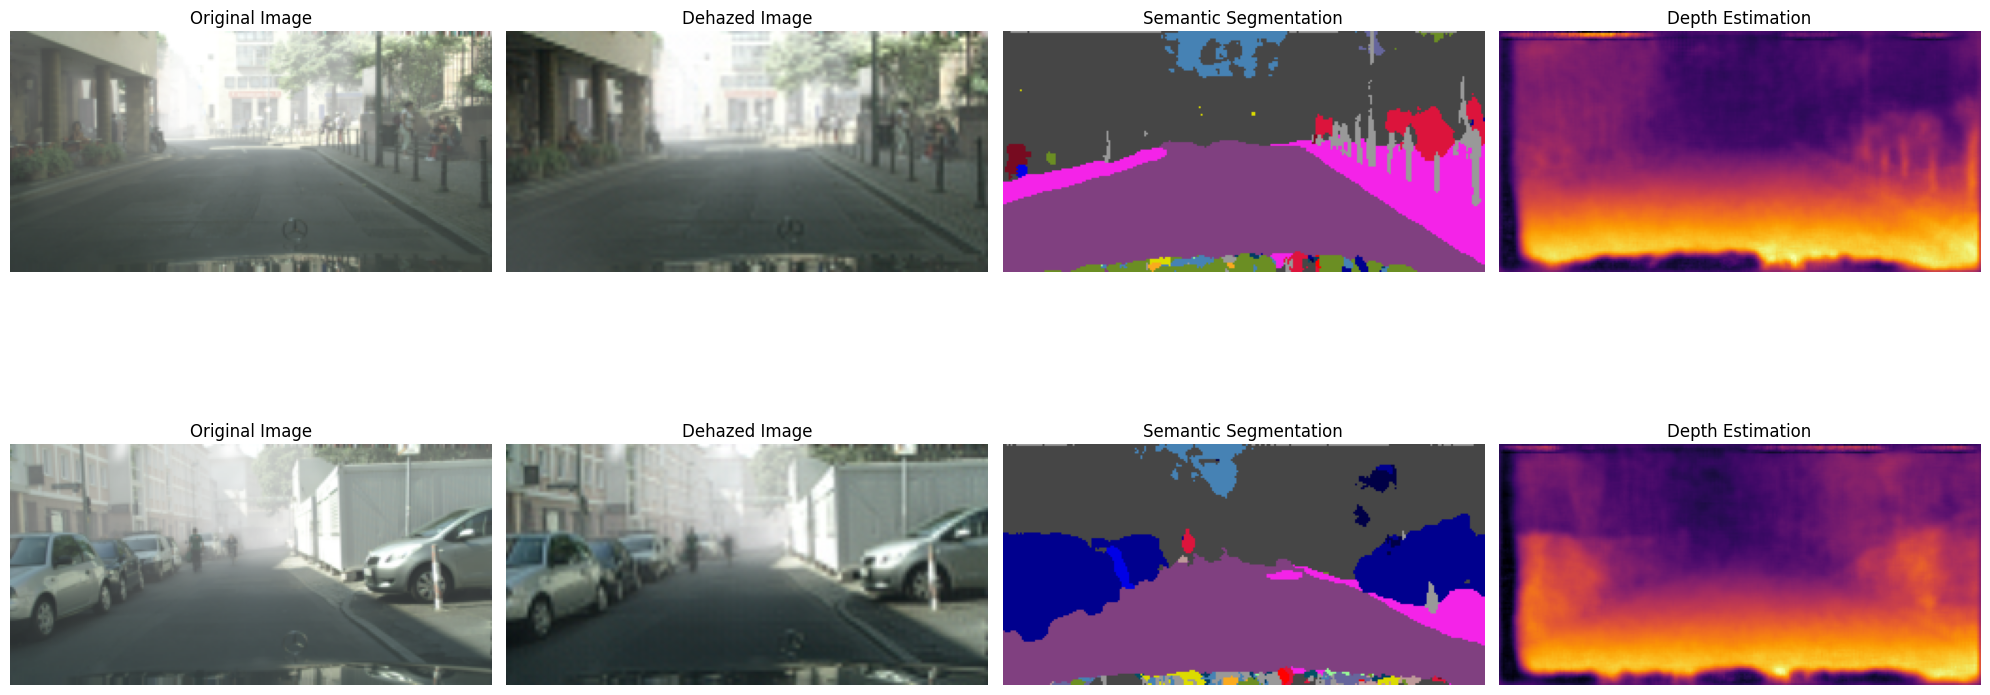

In [62]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms as T
from PIL import Image

# === Cityscapes Color Palette Based on Train ID ===
cityscapes_trainid_to_color = {
    0:  (128, 64, 128),  1:  (244, 35, 232),  2:  (70, 70, 70),   3:  (102, 102, 156),
    4:  (190, 153, 153), 5:  (153, 153, 153), 6:  (250, 170, 30), 7:  (220, 220, 0),
    8:  (107, 142, 35),  9:  (152, 251, 152), 10: (70, 130, 180), 11: (220, 20, 60),
    12: (255, 0, 0),     13: (0, 0, 142),     14: (0, 0, 70),     15: (0, 60, 100),
    16: (0, 80, 100),    17: (0, 0, 230),     18: (119, 11, 32),  19: (0, 0, 142),
    20: (0, 0, 0)
}

# === Decode semantic mask to RGB ===
def decode_semantic_mask(sem_mask, palette):
    h, w = sem_mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for train_id, color in palette.items():
        color_mask[sem_mask == train_id] = color
    return color_mask

# === Visualization with Dehazed Output ===
def visualize_results_with_dehaze(originals, dehazeds, semantic_outputs, depth_outputs):
    num_images = originals.shape[0]
    fig, axes = plt.subplots(num_images, 4, figsize=(20, num_images * 5))

    for i in range(num_images):
        # Original image
        orig_np = originals[i].cpu().numpy().transpose((1, 2, 0))
        axes[i, 0].imshow(orig_np)
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')

        # Dehazed image
        dehaze_np = dehazeds[i].cpu().numpy().transpose((1, 2, 0))
        axes[i, 1].imshow(dehaze_np)
        axes[i, 1].set_title('Dehazed Image')
        axes[i, 1].axis('off')

        # Semantic mask (decoded)
        sem_logits = semantic_outputs[i]  # Shape: [C, H, W]
        sem_mask = torch.argmax(sem_logits.squeeze(0), dim=0).cpu().numpy().astype(np.uint8)
        sem_rgb = decode_semantic_mask(sem_mask, cityscapes_trainid_to_color)
        axes[i, 2].imshow(sem_rgb)
        axes[i, 2].set_title('Semantic Segmentation')
        axes[i, 2].axis('off')

        # Depth map (normalize for visualization)
        depth_map = depth_outputs[i].squeeze().cpu().numpy()
        depth_min, depth_max = depth_map.min(), depth_map.max()
        depth_norm = (depth_map - depth_min) / (depth_max - depth_min + 1e-8)
        axes[i, 3].imshow(depth_norm, cmap='inferno')
        axes[i, 3].set_title('Depth Estimation')
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()

to_pil = T.ToPILImage()

model = GLPDepthWithSegmentation()
# Load model weights
model_path = 'GLPWithSegFormerModel'
checkpoint = torch.load(model_path, map_location=device)

model = torch.load(model_path, map_location=device) 
model.eval()

with torch.no_grad():
    for i, batch in enumerate(test_loader):
        if i < 1:
            continue

        # === Load two image paths ===
        image_paths = [
            f"dataset/foggy_data/Dense_Fog/0{num1}.png",
            f"dataset/foggy_data/Dense_Fog/0{num2}.png"
        ]

        # === Define transform ===
        transform = T.Compose([
            T.Resize((128, 256)),
            T.ToTensor()
        ])

        # === Load and preprocess both images ===
        images = [transform(Image.open(p).convert("RGB")) for p in image_paths]

        # === Stack and move to device ===
        images = torch.stack(images).to(device)  # Shape: [2, 3, 128, 256]

        # === Run dehazing ===
        dehazed_outputs = []
        seg_outputs = []
        depth_outputs = []

        for img in images:
            img = img.unsqueeze(0)  # Shape: [1, 3, H, W]
            dehazed = net(img)[1].squeeze(0)  # Assuming net returns [features, dehazed]
            dehazed_outputs.append(dehazed)
            
            print("dehazed",dehazed.unsqueeze(0).shape)
            prediction = model(img)

            semantic = prediction['semantic']
            depth = prediction['depth']

            if isinstance(semantic, np.ndarray):
                semantic = torch.from_numpy(semantic)
            if isinstance(depth, np.ndarray):
                depth = torch.from_numpy(depth)

            seg_outputs.append(semantic.squeeze(0))
            depth_outputs.append(depth.squeeze(0))
            # dehazed_outputs.append(img.squeeze(0))  # Placeholder for dehazed (replace if needed)

        # Stack everything for visualization
        originals = images.cpu()
        dehazeds = torch.stack(dehazed_outputs)
        sems = torch.stack(seg_outputs)
        depths = torch.stack(depth_outputs)

        visualize_results_with_dehaze(originals, dehazeds, sems, depths)
        break


C:\Users\abd\AppData\Local\Temp\ipykernel_48892\1022775753.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)
C:\U

dehazed torch.Size([1, 3, 128, 256])
dehazed torch.Size([1, 3, 128, 256])


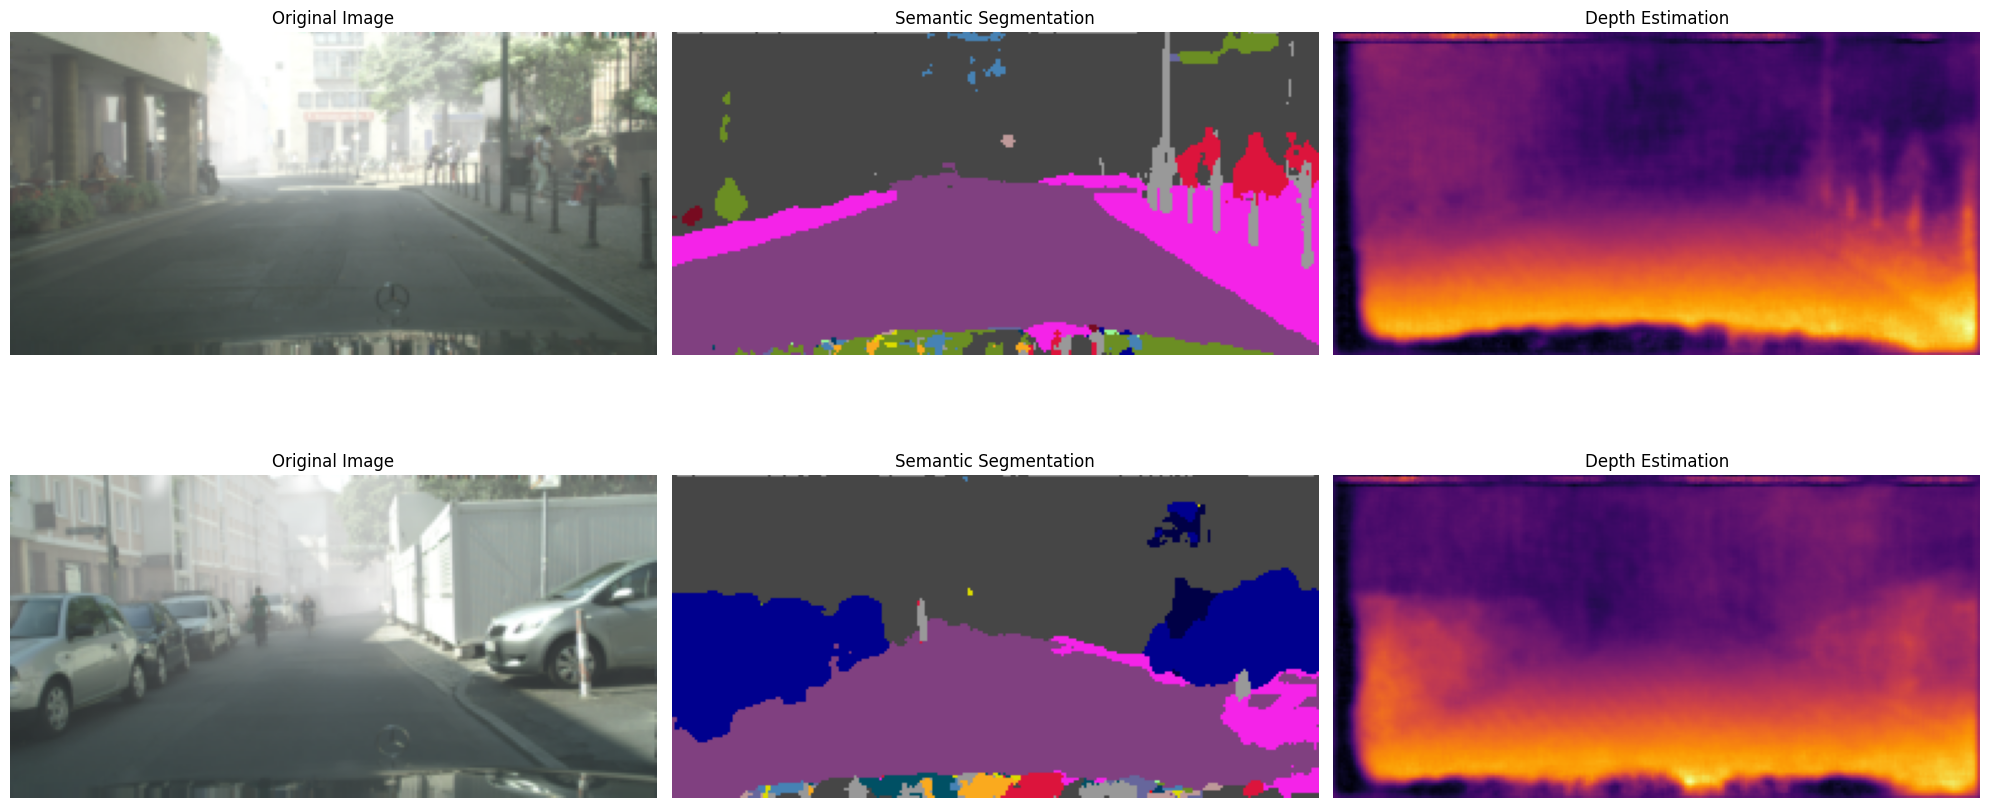

In [63]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms as T
from PIL import Image

# === Cityscapes Color Palette Based on Train ID ===
cityscapes_trainid_to_color = {
    0:  (128, 64, 128),  1:  (244, 35, 232),  2:  (70, 70, 70),   3:  (102, 102, 156),
    4:  (190, 153, 153), 5:  (153, 153, 153), 6:  (250, 170, 30), 7:  (220, 220, 0),
    8:  (107, 142, 35),  9:  (152, 251, 152), 10: (70, 130, 180), 11: (220, 20, 60),
    12: (255, 0, 0),     13: (0, 0, 142),     14: (0, 0, 70),     15: (0, 60, 100),
    16: (0, 80, 100),    17: (0, 0, 230),     18: (119, 11, 32),  19: (0, 0, 142),
    20: (0, 0, 0)
}

# === Decode semantic mask to RGB ===
def decode_semantic_mask(sem_mask, palette):
    h, w = sem_mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for train_id, color in palette.items():
        color_mask[sem_mask == train_id] = color
    return color_mask

# === Visualization with Dehazed Output ===
def visualize_results_with_dehaze(originals, dehazeds, semantic_outputs, depth_outputs):
    num_images = originals.shape[0]
    fig, axes = plt.subplots(num_images, 3, figsize=(20, num_images * 5))

    for i in range(num_images):
        # Original image
        orig_np = originals[i].cpu().numpy().transpose((1, 2, 0))
        axes[i, 0].imshow(orig_np)
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')

        # # Dehazed image
        # dehaze_np = dehazeds[i].cpu().numpy().transpose((1, 2, 0))
        # axes[i, 1].imshow(dehaze_np)
        # axes[i, 1].set_title('Dehazed Image')
        # axes[i, 1].axis('off')

        # Semantic mask (decoded)
        sem_logits = semantic_outputs[i]  # Shape: [C, H, W]
        sem_mask = torch.argmax(sem_logits.squeeze(0), dim=0).cpu().numpy().astype(np.uint8)
        sem_rgb = decode_semantic_mask(sem_mask, cityscapes_trainid_to_color)
        axes[i, 1].imshow(sem_rgb)
        axes[i, 1].set_title('Semantic Segmentation')
        axes[i, 1].axis('off')

        # Depth map (normalize for visualization)
        depth_map = depth_outputs[i].squeeze().cpu().numpy()
        depth_min, depth_max = depth_map.min(), depth_map.max()
        depth_norm = (depth_map - depth_min) / (depth_max - depth_min + 1e-8)
        axes[i, 2].imshow(depth_norm, cmap='inferno')
        axes[i, 2].set_title('Depth Estimation')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

to_pil = T.ToPILImage()

model = GLPDepthWithSegmentation()
# Load model weights
model_path = 'GLPWithSegFormerModel'
checkpoint = torch.load(model_path, map_location=device)

model = torch.load(model_path, map_location='cpu') 
model.eval()

with torch.no_grad():
    for i, batch in enumerate(test_loader):
        if i < 1:
            continue

        # === Load two image paths ===
        image_paths = [
            f"dataset/foggy_data/Dense_Fog/0{num1}.png",
            f"dataset/foggy_data/Dense_Fog/0{num2}.png"
        ]

        # === Define transform ===
        transform = T.Compose([
            T.Resize((128, 256)),
            T.ToTensor()
        ])

        # === Load and preprocess both images ===
        images = [transform(Image.open(p).convert("RGB")) for p in image_paths]

        # === Stack and move to device ===
        images = torch.stack(images).to(device)  # Shape: [2, 3, 128, 256]

        # === Run dehazing ===
        dehazed_outputs = []
        seg_outputs = []
        depth_outputs = []

        for img in images:
            img = img.unsqueeze(0)  # Shape: [1, 3, H, W]
            dehazed = net(img)[1].squeeze(0)  # Assuming net returns [features, dehazed]
            dehazed_outputs.append(dehazed)
            
            print("dehazed",dehazed.unsqueeze(0).shape)
            prediction = model(dehazed.unsqueeze(0).cpu())

            semantic = prediction['semantic']
            depth = prediction['depth']

            if isinstance(semantic, np.ndarray):
                semantic = torch.from_numpy(semantic)
            if isinstance(depth, np.ndarray):
                depth = torch.from_numpy(depth)

            seg_outputs.append(semantic.squeeze(0))
            depth_outputs.append(depth.squeeze(0))
            # dehazed_outputs.append(img.squeeze(0))  # Placeholder for dehazed (replace if needed)

        # Stack everything for visualization
        originals = images.cpu()
        dehazeds = torch.stack(dehazed_outputs)
        sems = torch.stack(seg_outputs)
        depths = torch.stack(depth_outputs)

        visualize_results_with_dehaze(originals, dehaze, sems, depths)
        break

C:\Users\abd\AppData\Local\Temp\ipykernel_48892\3515409817.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)
C:\U

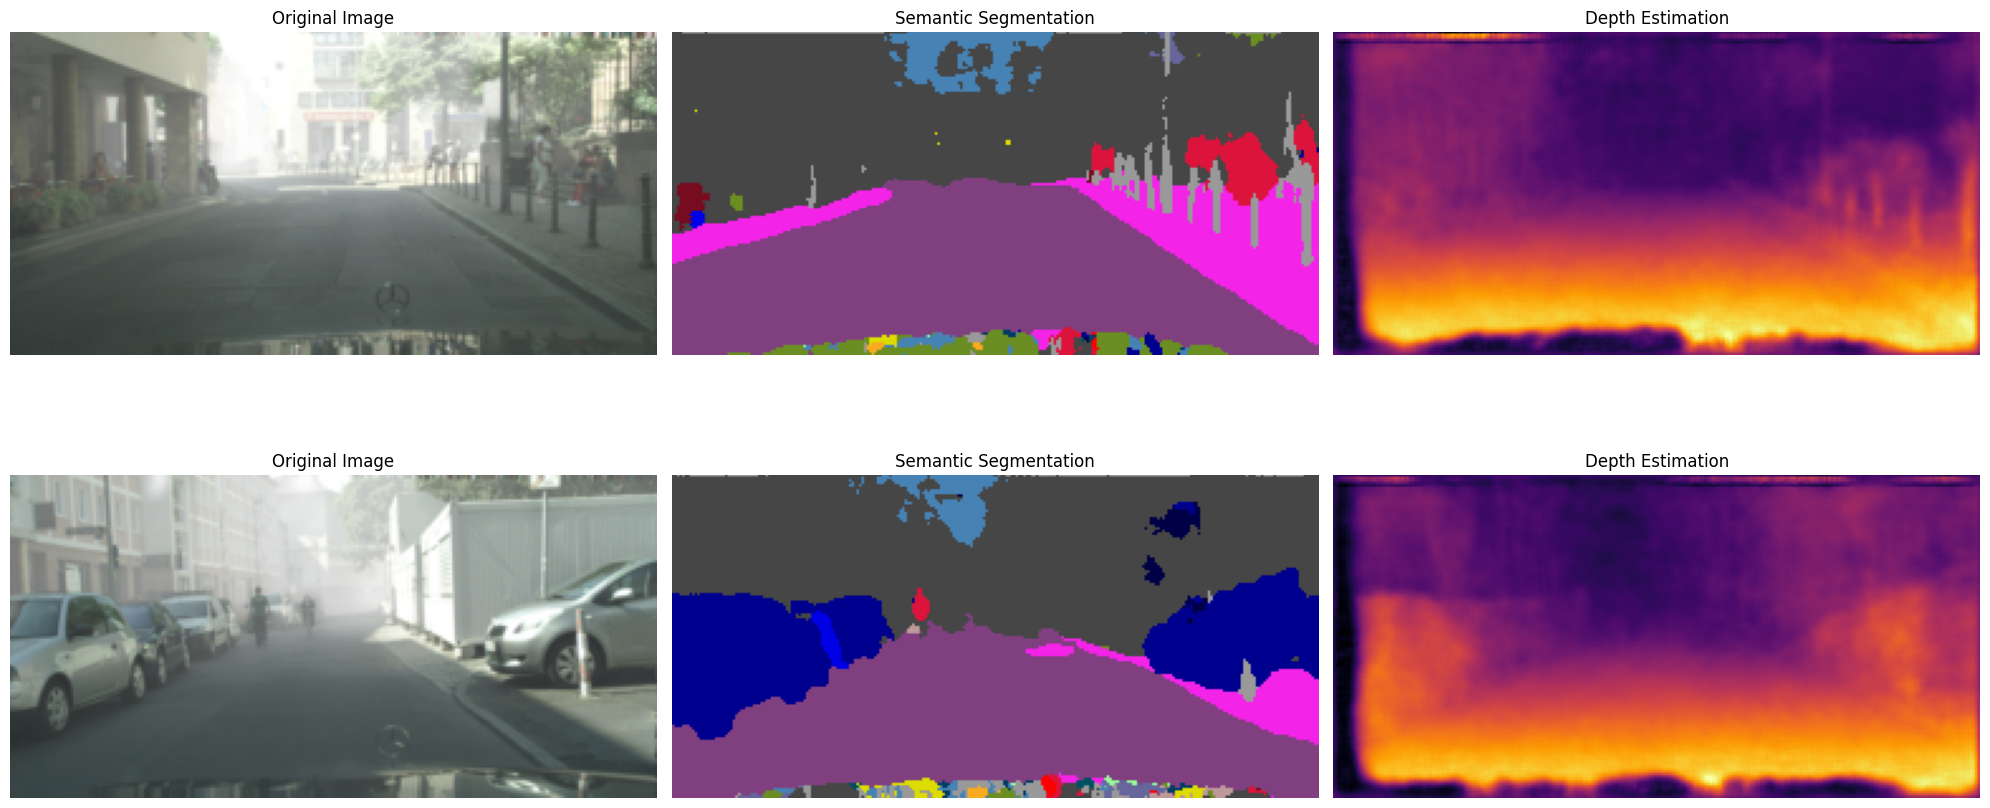

In [65]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms as T
from PIL import Image

# === Cityscapes Color Palette Based on Train ID ===
cityscapes_trainid_to_color = {
    0:  (128, 64, 128),  1:  (244, 35, 232),  2:  (70, 70, 70),   3:  (102, 102, 156),
    4:  (190, 153, 153), 5:  (153, 153, 153), 6:  (250, 170, 30), 7:  (220, 220, 0),
    8:  (107, 142, 35),  9:  (152, 251, 152), 10: (70, 130, 180), 11: (220, 20, 60),
    12: (255, 0, 0),     13: (0, 0, 142),     14: (0, 0, 70),     15: (0, 60, 100),
    16: (0, 80, 100),    17: (0, 0, 230),     18: (119, 11, 32),  19: (0, 0, 142),
    20: (0, 0, 0)
}

# === Decode semantic mask to RGB ===
def decode_semantic_mask(sem_mask, palette):
    h, w = sem_mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for train_id, color in palette.items():
        color_mask[sem_mask == train_id] = color
    return color_mask

# === Visualization with Dehazed Output ===
def visualize_results_with_dehaze(originals, dehazeds, semantic_outputs, depth_outputs):
    num_images = originals.shape[0]
    fig, axes = plt.subplots(num_images, 3, figsize=(20, num_images * 5))

    for i in range(num_images):
        # Original image
        orig_np = originals[i].cpu().numpy().transpose((1, 2, 0))
        axes[i, 0].imshow(orig_np)
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')

        # # Dehazed image
        # dehaze_np = dehazeds[i].cpu().numpy().transpose((1, 2, 0))
        # axes[i, 1].imshow(dehaze_np)
        # axes[i, 1].set_title('Dehazed Image')
        # axes[i, 1].axis('off')

        # Semantic mask (decoded)
        sem_logits = semantic_outputs[i]  # Shape: [C, H, W]
        sem_mask = torch.argmax(sem_logits.squeeze(0), dim=0).cpu().numpy().astype(np.uint8)
        sem_rgb = decode_semantic_mask(sem_mask, cityscapes_trainid_to_color)
        axes[i, 1].imshow(sem_rgb)
        axes[i, 1].set_title('Semantic Segmentation')
        axes[i, 1].axis('off')

        # Depth map (normalize for visualization)
        depth_map = depth_outputs[i].squeeze().cpu().numpy()
        depth_min, depth_max = depth_map.min(), depth_map.max()
        depth_norm = (depth_map - depth_min) / (depth_max - depth_min + 1e-8)
        axes[i, 2].imshow(depth_norm, cmap='inferno')
        axes[i, 2].set_title('Depth Estimation')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

to_pil = T.ToPILImage()

model = GLPDepthWithSegmentation()
# Load model weights
model_path = 'GLPWithSegFormerModel'
checkpoint = torch.load(model_path, map_location=device)

model = torch.load(model_path, map_location=device) 
model.eval()

with torch.no_grad():
    for i, batch in enumerate(test_loader):
        if i < 1:
            continue

        # === Load two image paths ===
        image_paths = [
            f"dataset/foggy_data/Dense_Fog/0{num1}.png",
            f"dataset/foggy_data/Dense_Fog/0{num2}.png"
        ]

        # === Define transform ===
        transform = T.Compose([
            T.Resize((128, 256)),
            T.ToTensor()
        ])

        # === Load and preprocess both images ===
        images = [transform(Image.open(p).convert("RGB")) for p in image_paths]

        # === Stack and move to device ===
        images = torch.stack(images).to(device)  # Shape: [2, 3, 128, 256]

        # === Run dehazing ===
        dehazed_outputs = []
        seg_outputs = []
        depth_outputs = []

        for img in images:
            img = img.unsqueeze(0)  # Shape: [1, 3, H, W]

            prediction = model(img)

            semantic = prediction['semantic']
            depth = prediction['depth']

            if isinstance(semantic, np.ndarray):
                semantic = torch.from_numpy(semantic)
            if isinstance(depth, np.ndarray):
                depth = torch.from_numpy(depth)

            seg_outputs.append(semantic.squeeze(0))
            depth_outputs.append(depth.squeeze(0))
            dehazed_outputs.append(img.squeeze(0))  # Placeholder for dehazed (replace if needed)

        # Stack everything for visualization
        originals = images.cpu()
        dehazeds = torch.stack(dehazed_outputs)
        sems = torch.stack(seg_outputs)
        depths = torch.stack(depth_outputs)

        visualize_results_with_dehaze(originals, dehazeds, sems, depths)
        break


In [66]:
# model = GLPDepthWithSegmentation()
# # Load model weights
# model_path = 'GLPWithSegFormerModel'
# checkpoint = torch.load(model_path, map_location=device)

# model = torch.load(model_path, map_location='cpu') 

# model.eval()  # Set model to evaluation mode

# # Step 3: Example inference (optional)
# # Load and preprocess example image
# img_path = 'dataset/RESIDE-6K/train/GT/2.jpg'
# image = Image.open(img_path).convert('RGB')
# from torchvision import transforms
# transform = transforms.Compose([
#     transforms.Resize((126, 256)),
#     transforms.ToTensor(),
# ])
# input_tensor = transform(image).unsqueeze(0).to(device)

# # Run inference
# with torch.no_grad():
#     output = model(input_tensor)

# # Print shape of output
# print("Output shape:", output.shape)